# Replication: Hypoglycemia and Hyperglycemia Detection from ECG with a Multi-Threshold Fusion Model

## Goal
This notebook replicates the pipeline described in the paper to detect glycemic states from ECG signals.

We use the standard clinical thresholds:
- **Hypoglycemia:** glucose < 70 mg/dL
- **Hyperglycemia:** glucose > 180 mg/dL
- **Normal:** otherwise

## What this notebook does
1. **Dataset indexing:** match ECG sessions with CGM (glucose) logs.
2. **Loading and cleaning:**
   - ECG cleaning + quality filtering.
   - Glucose cleaning + unit conversion to mg/dL.
3. **Beat processing and feature extraction:**
   - Beat delineation (P, Q, R, S, T).
   - Morphology features (per-beat).
   - RR-based features (HRV, per-interval).
4. **Interval building:** convert beat features into **1-minute non-overlapping windows**.
5. **Models and fusion:** train baseline models and the multi-threshold fusion model.
6. **Temporal validation:** chronological cross-validation to reduce leakage.

## Main outputs
- Model performance (AUC/metrics) for hypo and hyper detection.
- Comparison across model families (beat, interval, fusion).
- Plots: performance, feature importance, and physiological patterns.

## 1. Setup and Configuration
We initialize the environment and define the physiological parameters compliant with the paper:
* **Sampling Rate:** 250 Hz
* **Quality Threshold:** HRC > 90% (Only high-quality signal segments are used).
* **Glucose Thresholds:**
    * *Hypo:* < 70 mg/dL (Standard) + Fusion steps [55, 60, ..., 90]
    * *Hyper:* > 180 mg/dL (Standard) + Fusion steps [150, 165, ..., 250]

In [ ]:
import sys, subprocess
try:
    import neurokit2 as nk
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "neurokit2"])
    import neurokit2 as nk

import os, glob, re, time, gc, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# --- CONFIGURAZIONE ---
N_PAZIENTI = None          
N_CORES = -1            
FS = 250                
HRC_THRESHOLD = 90.0    

# Soglie Glucosio (mg/dL) - Sec 2.7
HYPO_LIMIT = 70
HYPER_LIMIT = 180
FUSION_HYPO = [55, 60, 65, 70, 75, 80, 85, 90]
FUSION_HYPER = [150, 165, 180, 200, 225, 250]

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
print("Setup completato.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 11.4 MB/s eta 0:00:00
Setup completato.


## 2. Dataset indexing

We build the list of usable sessions by matching:
- an **ECG** file for the session
- the corresponding **CGM / glucose** file

We keep only sessions where both files exist and can be parsed.

Output of this step:
- a table/list with `patient_id`, `session_id`, ECG path, and CGM path.

In [2]:
DATA_ROOT = "/kaggle/input/d1namo-ecg-glucose-data"
PATH_ECG = os.path.join(DATA_ROOT, "diabetes_subset_ecg_data", "diabetes_subset_ecg_data")
PATH_SENS = os.path.join(DATA_ROOT, "diabetes_subset_sensor_data", "diabetes_subset_sensor_data")
PATH_GLUC = os.path.join(DATA_ROOT, "diabetes_subset_pictures-glucose-food-insulin", "diabetes_subset_pictures-glucose-food-insulin")

def get_ids(path):
    parts = path.split(os.sep)
    subj = next((p for p in parts if re.fullmatch(r'\d{3}', p)), None)
    sess = next((p for p in parts if re.match(r'\d{4}_\d{2}_\d{2}', p)), None)
    return subj, sess

# 1. Indicizzazione
glucose_map = {}
for f in glob.glob(os.path.join(PATH_GLUC, "*", "glucose.csv")):
    s_id, _ = get_ids(f)
    if s_id: glucose_map[s_id] = f

session_list = []
ecg_files = sorted(glob.glob(os.path.join(PATH_ECG, "*", "sensor_data", "*", "*_ECG.csv")))

for ecg_path in ecg_files:
    s_id, sess_id = get_ids(ecg_path)
    if not s_id or not sess_id or s_id not in glucose_map: continue
    
    sum_path = os.path.join(PATH_SENS, s_id, "sensor_data", sess_id, f"{sess_id}_Summary.csv")
    if os.path.exists(sum_path):
        session_list.append({
            "subject": s_id,
            "session": sess_id,
            "ecg_path": ecg_path,
            "sum_path": sum_path,
            "gluc_path": glucose_map[s_id]
        })

df_index = pd.DataFrame(session_list)

# Filtro Pazienti
if N_PAZIENTI:
    targets = sorted(df_index['subject'].unique())[:N_PAZIENTI]
    df_index = df_index[df_index['subject'].isin(targets)].reset_index(drop=True)
    print(f"Processando {len(targets)} pazienti: {targets}")

print(f"Sessioni totali: {len(df_index)}")

Sessioni totali: 47


## 3. Data loading and signal processing

This section defines the functions used to read and clean raw data.

- **Glucose (CGM):**
  - remove invalid values
  - convert to **mg/dL**
  - keep timestamps consistent

- **ECG:**
  - load the signal
  - apply cleaning
  - compute a signal quality score (heart rate confidence)
  - discard segments that are likely corrupted (e.g., motion artifacts)

The goal is to avoid extracting features from low-quality ECG.

In [13]:
def load_glucose_clean(path):
    try:
        df = pd.read_csv(path, sep=None, engine='python')
        df.columns = [c.strip().lower().replace('#', '').strip() for c in df.columns]
        c_gluc = next((c for c in df.columns if 'gluc' in c), None)
        if 'date' in df.columns and 'time' in df.columns and c_gluc:
            ts = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
            vals = pd.to_numeric(df[c_gluc], errors='coerce')
            clean = pd.DataFrame({'Time': ts, 'Glucose': vals}).dropna().sort_values('Time')
            clean['Glucose'] = clean['Glucose'] * 18.0182 # mmol/L -> mg/dL
            return clean
    except: return None
    return None

def load_ecg_hrc(ecg_path, sum_path):
    """Gestisce header sporchi (# HR) e estrae HR raw + HRC senza Warning."""
    try:
        sum_df = pd.read_csv(sum_path)
        # Pulizia nomi colonne
        sum_df.columns = [c.replace('#', '').strip() for c in sum_df.columns]
        
        c_hr = next((c for c in sum_df.columns if c in ['HR', 'HeartRate', 'Rate']), None)
        c_hrc = next((c for c in sum_df.columns if 'Conf' in c or 'HRC' in c), None)
        c_time = next((c for c in sum_df.columns if 'Time' in c), None)

        sum_df[c_time] = pd.to_datetime(sum_df[c_time], dayfirst=True, errors='coerce')
        if sum_df[c_time].isna().all(): return None, None, None, None

        t_start = sum_df[c_time].iloc[0]
        
        # Estrazione HRC
        hrc = sum_df[c_hrc].fillna(0).values if c_hrc else np.zeros(len(sum_df))
        
        # Estrazione HR (Heart Rate) - CORREZIONE WARNING QUI
        # Usiamo .ffill() invece di .fillna(method='ffill')
        if c_hr:
            hr_raw = sum_df[c_hr].ffill().fillna(0).values 
        else:
            hr_raw = np.zeros(len(sum_df))

        ecg_df = pd.read_csv(ecg_path, usecols=['EcgWaveform'])
        sig = ecg_df['EcgWaveform'].fillna(0).values.astype(np.float32)
        times = t_start + pd.to_timedelta(np.arange(len(sig)) * (1e9/FS), unit='ns')

        return sig, times.values, hrc, hr_raw
    except: return None, None, None, None

## 4. Core engine: beat delineation and feature extraction

This is the most expensive step. For each session we do:

1. **Delineation:** detect P, Q, R, S, and T fiducial points for each beat.
2. **Quality filtering:** drop beats with low confidence or missing fiducial points.
3. **Per-beat features (morphology):**
   - peak amplitudes (P, Q, R, S, T)
   - time intervals and distances between fiducial points (e.g., QT, PR)
4. **Labeling:** assign each beat a glucose label using the nearest *future* CGM reading.

Note:
- results are cached to a Parquet file to speed up future runs.

In [45]:
parquet_path = "/kaggle/input/preprocessing/beats_df.parquet"
SKIP_DF_BUILD = os.path.exists(parquet_path)

if SKIP_DF_BUILD:
    print(f"✅ Trovato {parquet_path}. Salto la creazione di beats_df.")
    beats_df = pd.read_parquet(parquet_path)
else:
    def process_session(task):
        s, sess = task['subject'], task['session']
        try:
            # 1. Load Data (Include hr_raw e robustezza header definita nella Cella 3)
            sig_raw, times, hrc, hr_raw = load_ecg_hrc(task['ecg_path'], task['sum_path'])
            if sig_raw is None: return None

            # 2. Preprocessing (Neurokit cleaning)
            sig = nk.ecg_clean(sig_raw, sampling_rate=FS, method="neurokit")
            _, info = nk.ecg_peaks(sig, sampling_rate=FS)
            rpeaks = info['ECG_R_Peaks']

            # 3. Quality Filter (HRC > 90) [cite: 141]
            if len(rpeaks) < 100: return None
            # Mappa indici ECG (250Hz) a indici Summary (1Hz)
            r_sec = np.clip((rpeaks/FS).astype(int), 0, len(hrc)-1)
            rpeaks = rpeaks[hrc[r_sec] > HRC_THRESHOLD]
            if len(rpeaks) < 50: return None

            # 4. Delineation (P, Q, S, T peaks)
            # Usiamo il metodo 'peak' (dwt) che è standard per questo tipo di analisi
            waves = {'P':[],'Q':[],'S':[],'T':[]}
            
            # Chunking per velocità e gestione memoria (batch da 50k battiti)
            for i in range(0, len(rpeaks), 50000):
                batch = rpeaks[i:i+50000]
                try:
                    _, w = nk.ecg_delineate(sig, rpeaks=batch, sampling_rate=FS, method='peak')
                    for k in waves: waves[k].extend(w[f'ECG_{k}_Peaks'])
                except:
                    for k in waves: waves[k].extend([np.nan]*len(batch))

            # 5. Feature Extraction (Paper Section 2.4.1 & Fig 2)
            R = rpeaks
            P, Q, S, T = [np.array(waves[k]) for k in 'PQST']
            
            # Filtro: rimuove beat dove manca anche solo un picco (P, Q, S o T) [cite: 144]
            valid = ~(np.isnan(P)|np.isnan(Q)|np.isnan(S)|np.isnan(T))
            R, P, Q, S, T = R[valid], P[valid].astype(int), Q[valid].astype(int), S[valid].astype(int), T[valid].astype(int)

            if len(R) == 0: return None

            # Feature: HR raw dal dispositivo interpolato sui battiti [cite: 221]
            # (Usiamo hr_raw caricato dal Summary.csv)
            r_sec_valid = np.clip((R/FS).astype(int), 0, len(hr_raw)-1)
            beat_hr = hr_raw[r_sec_valid]

            K = 1000.0/FS # Conversione campioni -> ms
            
            # Base DataFrame
            data = {
                'subject': s, 'session': sess,
                'beat_time': times[R], 
                'rpeak_idx': R,
                'RR_ms': np.append(np.diff(R), np.nan)*K, # RR Interval
                'HR_device': beat_hr # HR from Zephyr provided features
            }

            # --- A. 5 Amplitudes (Paper Fig 2 "Amplitude features") ---
            for peak_name, peak_idxs in zip(['P','Q','R','S','T'], [P,Q,R,S,T]):
                data[f'amp_{peak_name}'] = sig[peak_idxs]

            # --- B. 30 Combination Features (10 Pairs x 3 Metrics) ---
            # Il paper cita: "9 Euclidean-based distances... 10 interval-based... 9 slopes"
            # Calcolando tutte le 10 combinazioni copriamo sicuramente tutto il set informativo.
            # Pairs: P-Q, P-R, P-S, P-T, Q-R, Q-S, Q-T, R-S, R-T, S-T
            pairs = [
                (P,Q,'PQ'), (P,R,'PR'), (P,S,'PS'), (P,T,'PT'),
                (Q,R,'QR'), (Q,S,'QS'), (Q,T,'QT'),
                (R,S,'RS'), (R,T,'RT'),
                (S,T,'ST')
            ]
            
            for i1, i2, n in pairs:
                # Interval (Time difference in ms)
                dt = (i2-i1)*K 
                # Amplitude difference (mV o uV a seconda del raw)
                da = sig[i2]-sig[i1]
            
                data[f'int_{n}'] = dt                # Interval-based feature
                data[f'dist_{n}'] = np.hypot(dt, da) # Euclidean distance feature
            
                # Slope feature (gestione divisione per zero)
                with np.errstate(divide='ignore', invalid='ignore'):
                    data[f'slope_{n}'] = np.nan_to_num(da/dt)

            df_beat = pd.DataFrame(data).dropna()

            # 6. Merge Glucosio
            df_gluc = load_glucose_clean(task['gluc_path'])
            if df_gluc is None: return None

            # Label Assignment: "The nearest CGM reading in the forward direction" 
            # Usiamo direction='forward' invece di 'nearest'
            df_merged = pd.merge_asof(
                df_beat.sort_values('beat_time'),
                df_gluc,
                left_on='beat_time', right_on='Time',
                direction='forward', 
                tolerance=pd.Timedelta('15min')
            )
            
            # Ritorniamo il dataframe pulito, rimuovendo righe senza glucosio associato
            return df_merged.dropna(subset=['Glucose']).drop(columns=['Time']), f"{s}-{sess}"

        except Exception as e:
            # print(f"Error in {s}-{sess}: {e}") # Debug only
            return None, None

    # --- ESECUZIONE PARALLELA CON BARRA DI PROGRESSO ---
    tasks = df_index.to_dict('records')
    print(f"🚀 Avvio elaborazione parallela su {len(tasks)} sessioni...")

    # return_as="generator" permette l'aggiornamento real-time della barra tqdm
    results_generator = Parallel(n_jobs=N_CORES, return_as="generator")(
        delayed(process_session)(t) for t in tasks
    )

    valid_dfs = []
    pbar = tqdm(results_generator, total=len(tasks), unit="sess")

    for res_tuple in pbar:
        if res_tuple is not None:
            df_res, session_name = res_tuple
            if df_res is not None and not df_res.empty:
                valid_dfs.append(df_res)
                # Mostra l'ultima sessione completata con successo nella barra
                pbar.set_postfix_str(f"Last: {session_name} OK")

    # Assembly Finale
    if valid_dfs:
        beats_df = pd.concat(valid_dfs, ignore_index=True)
        print(f"\n✅ [COMPLETATO] Dataset: {beats_df.shape}")
        print(f"🩸 Media Glucosio: {beats_df['Glucose'].mean():.2f} mg/dL") 
        print(f"Feature columns extracted: {len([c for c in beats_df.columns if 'amp_' in c or 'int_' in c or 'dist_' in c or 'slope_' in c]) + 2} (Should be near 35 + RR + HR)")
        display(beats_df.head())
    else:
        print("\n❌ [FAIL] Nessun dato estratto. Controlla i percorsi o i file di input.")

✅ Trovato /kaggle/input/preprocessing/beats_df.parquet. Salto la creazione di beats_df.


In [46]:
import os

parquet_path = "/kaggle/working/outputs/beats_df.parquet"

if os.path.exists(parquet_path):
    print(f"✅ File già presente, skip salvataggio: {parquet_path}")
else:
    # richiede pyarrow o fastparquet
    try:
        beats_df.to_parquet(parquet_path, index=False, engine="pyarrow")
    except Exception:
        beats_df.to_parquet(parquet_path, index=False)  # fallback engine auto
    print(f"✅ Salvato: {parquet_path} | shape={beats_df.shape}")

✅ File già presente, skip salvataggio: /kaggle/working/outputs/beats_df.parquet


## 5. Interval generation and HRV analysis

The paper evaluates predictions on **1-minute non-overlapping intervals**, not only on single beats.

For each 1-minute window we compute:
1. **Morphology aggregation:** average per-beat morphology features inside the window.
2. **HRV metrics:** compute HRV from clean RR intervals (e.g., SDNN, RMSSD, pNN50).
3. **Time-of-day features:** add circadian encoding (sine/cosine of the hour).

Output of this step:
- an interval-level dataset used by the interval models and the fusion model.

In [47]:
def get_hrv_paper_compliant_from_rr(rr_ms):
    """HRV time-domain from cleaned RR intervals (ms)."""
    rr_ms = np.asarray(rr_ms, dtype=float)
    rr_ms = rr_ms[np.isfinite(rr_ms)]
    
    if len(rr_ms) < 5:
        return {}
    
    diff_rr = np.diff(rr_ms)
    
    hrv = {}
    hrv["HRV_MeanNN"] = float(np.mean(rr_ms))
    hrv["HRV_SDNN"] = float(np.std(rr_ms, ddof=1))
    hrv["HRV_RMSSD"] = float(np.sqrt(np.mean(diff_rr**2))) if len(diff_rr) > 0 else 0.0
    hrv["HRV_pNN50"] = float(100.0 * np.mean(np.abs(diff_rr) > 50.0)) if len(diff_rr) > 0 else 0.0
    hrv["HRV_MinNN"] = float(np.min(rr_ms))
    hrv["HRV_MaxNN"] = float(np.max(rr_ms))
    hrv["HRV_Prc20NN"] = float(np.percentile(rr_ms, 20))
    hrv["HRV_Prc80NN"] = float(np.percentile(rr_ms, 80))
    hrv["HRV_IQRNN"] = float(np.percentile(rr_ms, 75) - np.percentile(rr_ms, 25))
    
    return hrv

print("Generazione Intervalli...")
if 'SKIP_DF_BUILD' in globals() and SKIP_DF_BUILD:
    print("✅ beats_df caricato da parquet.")

if 'RR_ms_clean' not in beats_df.columns:
    beats_df['RR_ms_clean'] = beats_df['RR_ms'].where(
        (beats_df['RR_ms'] >= 300) & (beats_df['RR_ms'] <= 2000)
    )

beats_df['interval_id'] = beats_df['beat_time'].dt.floor('1min')

rows = []
for (s, sess, t), g in tqdm(beats_df.groupby(['subject','session','interval_id'])):
    if len(g) < 20: 
        continue

    g = g.sort_values("rpeak_idx")

    hour_rad = 2 * np.pi * t.hour / 24.0

    d = {
        'subject': s, 'interval_start': t,
        'glucose': g['Glucose'].mean(),
        'hour_sin': np.sin(hour_rad),
        'hour_cos': np.cos(hour_rad),
        'n_beats': len(g)
    }

    cols = [c for c in g.columns if c.startswith(("int_", "slope_", "dist_", "amp_"))]
    cols = cols + (["HR_device"] if "HR_device" in g.columns else [])
    for c in cols: 
        d[f'mean_{c}'] = g[c].mean()

    rr_clean = g["RR_ms_clean"].dropna().values
    rr_clean = rr_clean[rr_clean > 0]
    d["n_beats_cleanRR"] = len(rr_clean)
    
    if len(rr_clean) >= 20:
        d.update(get_hrv_paper_compliant_from_rr(rr_clean))

    rows.append(d)

df_int = pd.DataFrame(rows).fillna(0)
print(f"Intervalli pronti: {len(df_int)}")

Generazione Intervalli...
✅ beats_df caricato da parquet.


  0%|          | 0/19446 [00:00<?, ?it/s]

Intervalli pronti: 14581


In [48]:
import os

int_parquet_path = "/kaggle/working/outputs/df_int.parquet"

if os.path.exists(int_parquet_path):
    print(f"✅ File già presente, skip salvataggio: {int_parquet_path}")
else:
    try:
        df_int.to_parquet(int_parquet_path, index=False, engine="pyarrow")
    except Exception:
        df_int.to_parquet(int_parquet_path, index=False)  # fallback engine auto
    print(f"✅ Salvato: {int_parquet_path} | shape={df_int.shape}")

✅ File già presente, skip salvataggio: /kaggle/working/outputs/df_int.parquet


## 6. Exploratory analysis and quality control

Before training, we run basic checks to confirm data integrity:

1. **RR interval distribution:** values should stay in a physiological range.
2. **Glucose distribution:** check class imbalance (hypo / normal / hyper).
3. **Signal examples:** compare clean vs noisy ECG segments.

These plots help detect preprocessing mistakes and sessions that should be excluded.


DATASET QUALITY CHECK

1️⃣  DATASET STRUCTURE

   beats_df:   950,668 rows × 44 cols
   df_int:      14,581 rows × 52 cols
   Subjects:         9
   Sessions:        39

   ✅ 35 morphology features
   ✅ 9 HRV features

2️⃣  RR INTERVAL FILTERING

   Raw RR:        950,668 beats
   Filtered:       81,160 beats ( 8.54%) → removed (outside [300, 2000] ms)
   Clean:         869,508 beats (91.46%)
   Raw median:      740.0 ms ( 81.1 bpm)
   Clean median:    716.0 ms ( 83.8 bpm)

3️⃣  GLUCOSE CONDITIONS

   HYPO    :  1,165 intervals (  8.0%) | glucose μ=  53.7 mg/dL
   Normal  :  9,189 intervals ( 63.0%) | glucose μ= 124.6 mg/dL
   HYPER   :  4,227 intervals ( 29.0%) | glucose μ= 240.0 mg/dL


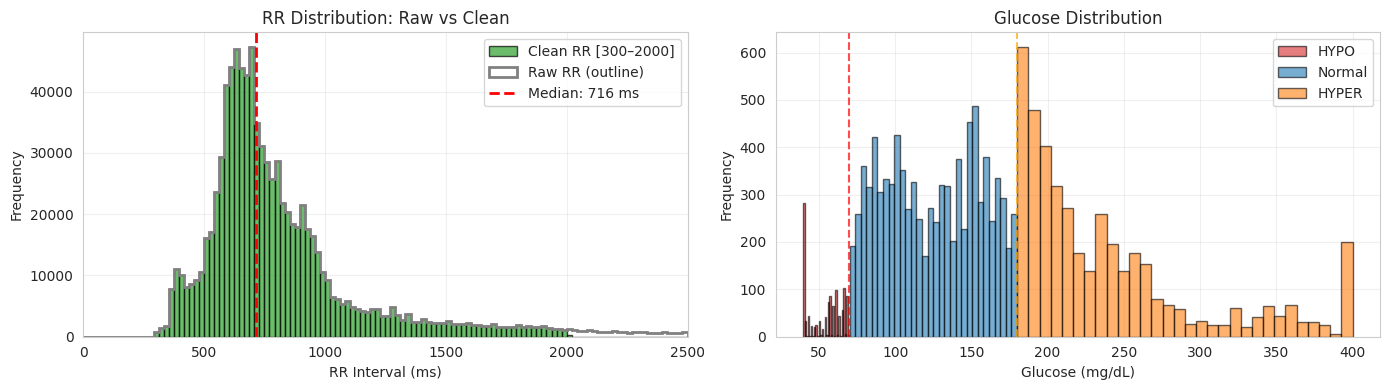


4️⃣  SESSION QUALITY ASSESSMENT

📊 Quality Metrics per Sessione:

   Total sessions: 39
   Good sessions:  26 (66.7%)
   Bad sessions:   13 (33.3%)

📍 Bad sessions breakdown:
   Low_coverage: 13

📋 Details of bad sessions:
   001-2014_10_04-06_34_57: Low_coverage (coverage=64.5%, RR_med=772ms, HR=2.7/10s)
   002-2014_10_04-17_43_12: Low_coverage (coverage=79.2%, RR_med=640ms, HR=4.8/10s)
   004-2014_10_04-06_32_58: Low_coverage (coverage=59.0%, RR_med=872ms, HR=2.8/10s)
   004-2014_10_04-16_49_30: Low_coverage (coverage=41.9%, RR_med=1044ms, HR=1.1/10s)
   005-2014_10_01-10_40_51: Low_coverage (coverage=49.6%, RR_med=932ms, HR=2.4/10s)
   005-2014_10_02-09_23_58: Low_coverage (coverage=66.5%, RR_med=912ms, HR=3.7/10s)
   005-2014_10_02-11_40_30: Low_coverage (coverage=55.1%, RR_med=956ms, HR=2.8/10s)
   005-2014_10_03-08_42_25: Low_coverage (coverage=57.6%, RR_med=932ms, HR=2.3/10s)
   005-2014_10_04-08_02_17: Low_coverage (coverage=36.9%, RR_med=958ms, HR=1.5/10s)
   009-2014_10_02-0

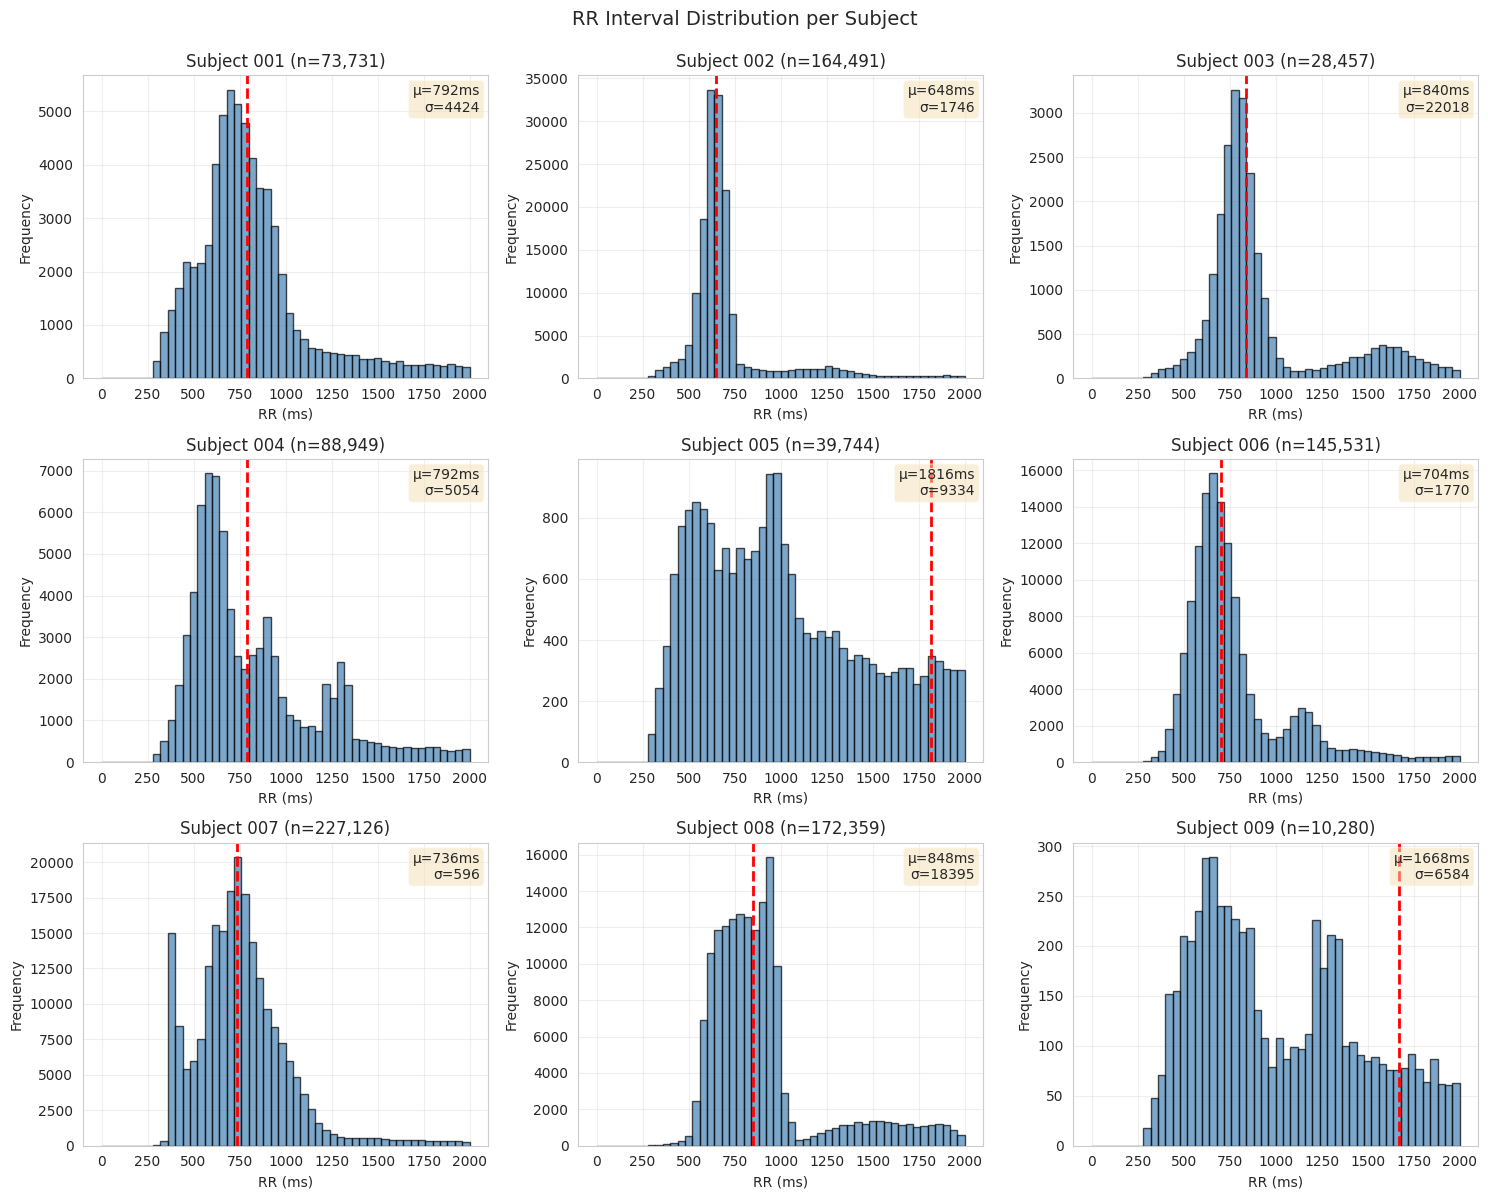


📊 Visual Comparison: Good vs Bad ECG Windows:

✅ GOOD Session: 001-2014_10_01-10_09_39 (OK)
❌ BAD Session: 001-2014_10_04-06_34_57 (Low_coverage)


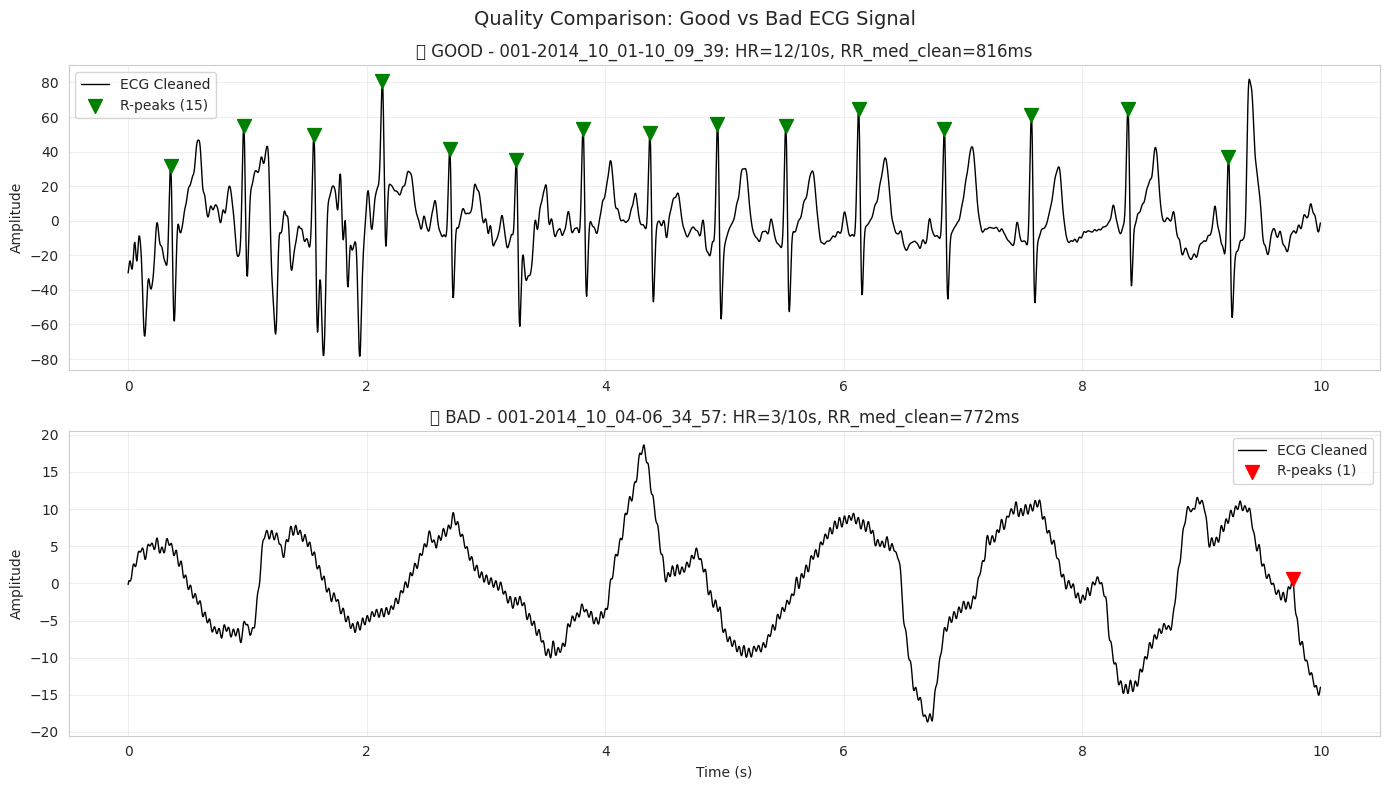


✅ QC COMPLETE - Session metrics calculated, ready for filtering



In [49]:
print("\n" + "="*80)
print("DATASET QUALITY CHECK")
print("="*80 + "\n")

# --- 1. STRUCTURE VALIDATION ---
print("1️⃣  DATASET STRUCTURE\n")
print(f"   beats_df:  {beats_df.shape[0]:>8,} rows × {beats_df.shape[1]:>2} cols")
print(f"   df_int:    {df_int.shape[0]:>8,} rows × {df_int.shape[1]:>2} cols")
print(f"   Subjects:  {beats_df['subject'].nunique():>8,}")
print(f"   Sessions:  {beats_df['session'].nunique():>8,}\n")

# Check morphology features
morph_cols = [c for c in beats_df.columns if c.startswith(('amp_', 'int_', 'dist_', 'slope_'))]
hrv_cols = [c for c in df_int.columns if c.startswith(("HRV_", "hrv_"))]
print(f"   ✅ {len(morph_cols)} morphology features")
print(f"   ✅ {len(hrv_cols)} HRV features\n")

# --- 2. RR FILTERING (CRITICAL STEP) ---
print("2️⃣  RR INTERVAL FILTERING\n")

# Create filtered RR for HRV and aggregations (NaN for outliers, not clipped)
beats_df['RR_ms_clean'] = beats_df['RR_ms'].where(
    (beats_df['RR_ms'] >= 300) & (beats_df['RR_ms'] <= 2000)
)

rr_raw = beats_df['RR_ms'].dropna()
rr_clean = beats_df['RR_ms_clean'].dropna()

n_outliers = len(rr_raw) - len(rr_clean)
pct_outliers = 100 * n_outliers / len(rr_raw)
pct_clean = 100 - pct_outliers

print(f"   Raw RR:       {len(rr_raw):>8,} beats")
print(f"   Filtered:     {n_outliers:>8,} beats ({pct_outliers:5.2f}%) → removed (outside [300, 2000] ms)")
print(f"   Clean:        {len(rr_clean):>8,} beats ({pct_clean:5.2f}%)")
print(f"   Raw median:   {rr_raw.median():>8.1f} ms ({60000/rr_raw.median():5.1f} bpm)")
print(f"   Clean median: {rr_clean.median():>8.1f} ms ({60000/rr_clean.median():5.1f} bpm)\n")

# --- 3. GLUCOSE DISTRIBUTION ---
print("3️⃣  GLUCOSE CONDITIONS\n")

df_int['Condition'] = 'Normal'
df_int.loc[df_int['glucose'] < HYPO_LIMIT, 'Condition'] = 'HYPO'
df_int.loc[df_int['glucose'] > HYPER_LIMIT, 'Condition'] = 'HYPER'

for cond in ['HYPO', 'Normal', 'HYPER']:
    n = (df_int['Condition'] == cond).sum()
    pct = 100 * n / len(df_int)
    g_mean = df_int.loc[df_int['Condition'] == cond, 'glucose'].mean()
    print(f"   {cond:8s}: {n:>6,} intervals ({pct:5.1f}%) | glucose μ={g_mean:6.1f} mg/dL")

# --- 4. VISUALIZATION (BETTER: raw as outline, clean as filled) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_range = (0, 2500)
bins = 120

# Clean filled histogram
axes[0].hist(rr_clean, bins=bins, range=plot_range,
             alpha=0.7, color='#2ca02c', edgecolor='black',
             label='Clean RR [300–2000]')

# Raw as outline (so it never gets hidden)
axes[0].hist(rr_raw, bins=bins, range=plot_range,
             histtype='step', linewidth=2, color='gray',
             label='Raw RR (outline)')

axes[0].axvline(rr_clean.median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {rr_clean.median():.0f} ms')

axes[0].set_xlabel('RR Interval (ms)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('RR Distribution: Raw vs Clean')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(*plot_range)


# Glucose distribution by condition
colors = {'HYPO': '#d62728', 'Normal': '#1f77b4', 'HYPER': '#ff7f0e'}
for cond in ['HYPO', 'Normal', 'HYPER']:
    data = df_int.loc[df_int['Condition'] == cond, 'glucose'].dropna()
    axes[1].hist(data, bins=30, alpha=0.6, label=cond, color=colors[cond], edgecolor='black')

axes[1].axvline(HYPO_LIMIT, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].axvline(HYPER_LIMIT, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Glucose (mg/dL)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Glucose Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- 5. SESSION QUALITY METRICS ---
print("\n" + "="*80)
print("4️⃣  SESSION QUALITY ASSESSMENT")
print("="*80 + "\n")

print("📊 Quality Metrics per Sessione:\n")

session_stats = []
for (subj, sess), g in beats_df.groupby(['subject', 'session']):
    rr_raw = g['RR_ms'].dropna()
    rr_clean = g['RR_ms_clean'].dropna()
    
    if len(rr_raw) < 10:
        continue
    
    # Duration check (skip if too short)
    duration_s = (g['beat_time'].max() - g['beat_time'].min()).total_seconds()
    if duration_s < 60:
        continue
    
    # Metric 1: RR coverage (% of clean RR out of raw)
    coverage = len(rr_clean) / len(rr_raw) if len(rr_raw) > 0 else 0
    
    # Metric 2: RR median (from clean data)
    rr_median_clean = rr_clean.median() if len(rr_clean) > 0 else np.nan
    rr_median_raw = rr_raw.median() if len(rr_raw) > 0 else np.nan
    rr_ok = (350 <= rr_median_clean <= 1200) if not np.isnan(rr_median_clean) else False
    
    # Metric 3: Beats per 10s (indicator only, not hard criterion)
    beats_per_10s = (len(g) / duration_s * 10) if duration_s > 0 else 0
    
    # Criterion: sessione da scartare?
    discard = False
    discard_reason = []
    
    if coverage < 0.8:
        discard = True
        discard_reason.append("Low_coverage")
    if not rr_ok:
        discard = True
        discard_reason.append("RR_nonphysio")
    if beats_per_10s < 6:
        # Soft warning, but don't discard on this alone
        pass
    
    stats = {
        'subject': subj,
        'session': sess,
        'n_beats': len(g),
        'duration_s': duration_s,
        'beats_per_10s': beats_per_10s,
        'rr_median_raw': rr_median_raw,
        'rr_median_clean': rr_median_clean,
        'coverage': coverage,
        'rr_ok': rr_ok,
        'discard': discard,
        'discard_reason': ','.join(discard_reason) if discard_reason else 'OK'
    }
    session_stats.append(stats)

df_sess = pd.DataFrame(session_stats)

# Summary
n_total = len(df_sess)
n_good = (~df_sess['discard']).sum()
n_discard = df_sess['discard'].sum()

print(f"   Total sessions: {n_total}")
print(f"   Good sessions:  {n_good} ({100*n_good/n_total:.1f}%)")
print(f"   Bad sessions:   {n_discard} ({100*n_discard/n_total:.1f}%)\n")

if n_discard > 0:
    print(f"📍 Bad sessions breakdown:")
    bad = df_sess[df_sess['discard']]
    for reason in ['Low_coverage', 'RR_nonphysio']:
        count = (bad['discard_reason'].str.contains(reason)).sum()
        if count > 0:
            print(f"   {reason}: {count}")
    print()
    
    print("📋 Details of bad sessions:")
    for idx, row in bad.iterrows():
        print(f"   {row['subject']}-{row['session']}: {row['discard_reason']} " +
              f"(coverage={row['coverage']:.1%}, RR_med={row['rr_median_clean']:.0f}ms, HR={row['beats_per_10s']:.1f}/10s)")


# 5.2 Visualizzazione distribuzione per soggetto
print("\n📈 Distribuzione RR per Subject:\n")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, subj in enumerate(sorted(beats_df['subject'].unique())):
    if i >= 9:
        break
    subj_rr = beats_df[beats_df['subject'] == subj]['RR_ms'].dropna()
    
    axes[i].hist(subj_rr, bins=50, range=(0, 2000), alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].axvline(subj_rr.median(), color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f"Subject {subj} (n={len(subj_rr):,})")
    axes[i].set_xlabel('RR (ms)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)
    
    # Aggiungi testo con statistiche
    axes[i].text(0.98, 0.97, f'μ={subj_rr.median():.0f}ms\nσ={subj_rr.std():.0f}',
                transform=axes[i].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('RR Interval Distribution per Subject', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# 5.3 Visual Comparison: Good vs Bad sessions
print("\n📊 Visual Comparison: Good vs Bad ECG Windows:\n")

try:
    if 'df_index' not in globals() or df_index.empty or 'subject' not in df_index.columns:
        print("   ⚠️  df_index not available - Skipping ECG visualization")
    else:
        # Pick 1 good and 1 bad session for visualization
        good_sess = df_sess[~df_sess['discard']].iloc[0] if (~df_sess['discard']).sum() > 0 else None
        bad_sess = df_sess[df_sess['discard']].iloc[0] if df_sess['discard'].sum() > 0 else None
        
        fig = None
        for label, sess_row in [("✅ GOOD", good_sess), ("❌ BAD", bad_sess)]:
            if sess_row is None:
                continue
            
            print(f"{label} Session: {sess_row['subject']}-{sess_row['session']} " +
                  f"({sess_row['discard_reason']})")
            
            sess_idx_row = df_index[(df_index['subject'] == sess_row['subject']) & 
                                     (df_index['session'] == sess_row['session'])]
            if len(sess_idx_row) == 0:
                print("      Not found in df_index")
                continue
            
            sess_idx_row = sess_idx_row.iloc[0]
            sig_raw, times, hrc, _ = load_ecg_hrc(sess_idx_row['ecg_path'], sess_idx_row['sum_path'])
            
            if sig_raw is None:
                print("      Cannot load signal")
                continue
            
            sig = nk.ecg_clean(sig_raw, sampling_rate=FS, method="neurokit")
            _, info = nk.ecg_peaks(sig, sampling_rate=FS)
            rpeaks = info['ECG_R_Peaks']
            
            # Find high-quality window
            high_hrc_idx = np.where(hrc > 90)[0]
            if len(high_hrc_idx) == 0:
                print("      No high-HRC window found")
                continue
            
            mid_sec = high_hrc_idx[len(high_hrc_idx)//2]
            start = int(max(0, mid_sec * FS - 5*FS))
            end = min(len(sig), start + int(10*FS))
            
            segment = sig[start:end]
            time_axis = np.arange(len(segment)) / FS
            rpeaks_in_seg = rpeaks[(rpeaks >= start) & (rpeaks < end)] - start
            
            if fig is None:
                fig, axes = plt.subplots(2, 1, figsize=(14, 8))
            else:
                ax_idx = 1 if label == "❌ BAD" else 0
            
            ax = axes[1] if label == "❌ BAD" else axes[0]
            ax.plot(time_axis, segment, color='black', linewidth=1, label='ECG Cleaned')
            ax.scatter(rpeaks_in_seg / FS, segment[rpeaks_in_seg], 
                      color='red' if label == "❌ BAD" else 'green', 
                      s=100, marker='v', zorder=5, label=f'R-peaks ({len(rpeaks_in_seg)})')
            ax.set_title(f"{label} - {sess_row['subject']}-{sess_row['session']}: " +
                        f"HR={sess_row['beats_per_10s']:.0f}/10s, RR_med_clean={sess_row['rr_median_clean']:.0f}ms")
            ax.set_ylabel('Amplitude')
            ax.set_xlabel('Time (s)' if label == "❌ BAD" else '')
            ax.legend()
            ax.grid(alpha=0.3)
        
        if fig is not None:
            plt.suptitle('Quality Comparison: Good vs Bad ECG Signal', fontsize=14)
            plt.tight_layout()
            plt.show()
            
except Exception as e:
    print(f"   ⚠️  Visualization failed: {str(e)[:80]}")
    # Trova una sessione "buona" (median vicino a 700ms)
    good_sess = df_sess.iloc[(df_sess['rr_median_clean'] - 700).abs().argmin()]
    sample_subj = good_sess['subject']
    sample_sess = good_sess['session']

    print(f"   Caricamento: {sample_subj}-{sample_sess} (RR median={good_sess['rr_median']:.0f}ms)...")

    # Carica il segnale di esempio
    if 'df_index' not in globals() or df_index.empty or 'subject' not in df_index.columns:
        print("   ⚠️  df_index not available - Skipping ECG visualization")
    else:
        sample_row = df_index[(df_index['subject'] == sample_subj) & 
                               (df_index['session'] == sample_sess)].iloc[0]
        sig_raw, times, hrc, _ = load_ecg_hrc(sample_row['ecg_path'], sample_row['sum_path'])

        if sig_raw is not None:
            sig = nk.ecg_clean(sig_raw, sampling_rate=FS, method="neurokit")
            _, info = nk.ecg_peaks(sig, sampling_rate=FS)
            rpeaks = info['ECG_R_Peaks']
            
            # Zoom su 10 secondi con alta HRC
            high_hrc_idx = np.where(hrc > 95)[0]
            if len(high_hrc_idx) > 0:
                mid_sec = high_hrc_idx[len(high_hrc_idx)//2]
                start = int(mid_sec * FS)
                end = start + int(10 * FS)
                
                segment = sig[start:end]
                time_axis = np.arange(len(segment)) / FS
                rpeaks_in_seg = rpeaks[(rpeaks >= start) & (rpeaks < end)] - start
                
                fig, axes = plt.subplots(2, 1, figsize=(16, 8))
                
                # Segnale completo
                axes[0].plot(time_axis, segment, color='black', linewidth=0.8, label='ECG Cleaned')
                axes[0].scatter(rpeaks_in_seg / FS, segment[rpeaks_in_seg], 
                               color='red', s=80, zorder=5, label=f'R-peaks (n={len(rpeaks_in_seg)})')
                axes[0].set_title(f'ECG with R-peaks: {sample_subj}-{sample_sess} (10s window)')
                axes[0].set_xlabel('Time (s)')
                axes[0].set_ylabel('Amplitude')
                axes[0].legend()
                axes[0].grid(alpha=0.3)
                
                # Zoom su 3 battiti
                if len(rpeaks_in_seg) >= 3:
                    zoom_start = int(rpeaks_in_seg[0] - 0.2*FS)
                    zoom_end = int(rpeaks_in_seg[2] + 0.3*FS)
                    zoom_start = max(0, zoom_start)
                    zoom_end = min(len(segment), zoom_end)
                    
                    zoom_seg = segment[zoom_start:zoom_end]
                    zoom_time = np.arange(len(zoom_seg)) / FS
                    zoom_rpeaks = rpeaks_in_seg[(rpeaks_in_seg >= zoom_start) & (rpeaks_in_seg < zoom_end)] - zoom_start
                    
                    axes[1].plot(zoom_time, zoom_seg, color='black', linewidth=1.5, label='ECG')
                    axes[1].scatter(zoom_rpeaks / FS, zoom_seg[zoom_rpeaks], 
                                   color='red', s=150, marker='v', zorder=5, label='R-peaks')
                    axes[1].set_title('Zoom: 3 beats detail')
                    axes[1].set_xlabel('Time (s)')
                    axes[1].set_ylabel('Amplitude')
                    axes[1].legend()
                    axes[1].grid(alpha=0.3)
                    
                    # Calcola RR tra i primi 2 picchi
                    if len(zoom_rpeaks) >= 2:
                        rr_example = (zoom_rpeaks[1] - zoom_rpeaks[0]) / FS * 1000
                        axes[1].text(0.5, 0.95, f'RR = {rr_example:.0f} ms ({60000/rr_example:.0f} bpm)',
                                    transform=axes[1].transAxes, ha='center', va='top',
                                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                                    fontsize=12, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                print("   ✅ Visualizzazione completata - Verifica manualmente la qualità dei picchi")
        else:
            print("   ⚠️  Impossibile caricare il segnale di esempio")
            
except Exception as e:
    print(f"   ⚠️  ECG visualization skipped ({str(e)[:50]}...)")

print("\n" + "="*80)
print("✅ QC COMPLETE - Session metrics calculated, ready for filtering")
print("="*80 + "\n")

In [50]:
# --- robust keys ---
good_mask = (df_sess['discard'] == False)
good_keys = set(zip(df_sess.loc[good_mask, "subject"],
                    df_sess.loc[good_mask, "session"]))

# beats_df
before = len(beats_df)
beats_df_clean = beats_df[beats_df.set_index(["subject","session"]).index.isin(good_keys)].copy()
after = len(beats_df_clean)
print(f"beats_df: {before:,} -> {after:,} (removed {(before-after):,})")


import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def get_hrv_paper_compliant_from_rr(rr_ms):
    rr_ms = np.asarray(rr_ms, dtype=float)
    rr_ms = rr_ms[np.isfinite(rr_ms)]
    rr_ms = rr_ms[rr_ms > 0]
    if len(rr_ms) < 5:
        return {}

    diff_rr = np.diff(rr_ms)

    hrv = {}
    hrv["HRV_MeanNN"] = float(np.mean(rr_ms))
    hrv["HRV_SDNN"] = float(np.std(rr_ms, ddof=1)) if len(rr_ms) > 1 else 0.0
    hrv["HRV_RMSSD"] = float(np.sqrt(np.mean(diff_rr**2))) if len(diff_rr) > 0 else 0.0
    hrv["HRV_pNN50"] = float(100.0 * np.mean(np.abs(diff_rr) > 50.0)) if len(diff_rr) > 0 else 0.0

    hrv["HRV_MinNN"] = float(np.min(rr_ms))
    hrv["HRV_MaxNN"] = float(np.max(rr_ms))
    hrv["HRV_Prc20NN"] = float(np.percentile(rr_ms, 20))
    hrv["HRV_Prc80NN"] = float(np.percentile(rr_ms, 80))
    hrv["HRV_IQRNN"] = float(np.percentile(rr_ms, 75) - np.percentile(rr_ms, 25))
    return hrv


# --- safety: RR_ms_clean must exist ---
if "RR_ms_clean" not in beats_df_clean.columns:
    beats_df_clean["RR_ms_clean"] = beats_df_clean["RR_ms"].where(
        (beats_df_clean["RR_ms"] >= 300) & (beats_df_clean["RR_ms"] <= 2000)
    )

# --- interval id ---
beats_df_clean = beats_df_clean.copy()
beats_df_clean["interval_start"] = beats_df_clean["beat_time"].dt.floor("1min")

# --- columns for morphology aggregation ---
morph_cols = [c for c in beats_df_clean.columns if c.startswith(("int_", "dist_", "slope_", "amp_"))]
if "HR_device" in beats_df_clean.columns:
    morph_cols = morph_cols + ["HR_device"]

rows = []
gb = beats_df_clean.groupby(["subject", "interval_start"], sort=False)

for (subj, t), g in tqdm(gb, total=gb.ngroups, desc="Rebuilding df_int_clean"):
    if len(g) < 20:
        continue

    # time features
    hour_rad = 2 * np.pi * t.hour / 24.0

    d = {
        "subject": subj,
        "interval_start": t,
        "glucose": float(g["Glucose"].mean()),
        "hour_sin": float(np.sin(hour_rad)),
        "hour_cos": float(np.cos(hour_rad)),
        "n_beats": int(len(g)),
    }

    # morphology means
    for c in morph_cols:
        d[f"mean_{c}"] = float(g[c].mean())

    # HRV from clean RR (order matters)
    g_sorted = g.sort_values("rpeak_idx") if "rpeak_idx" in g.columns else g
    rr_clean = g_sorted["RR_ms_clean"].dropna().values
    rr_clean = rr_clean[np.isfinite(rr_clean)]
    rr_clean = rr_clean[rr_clean > 0]

    d["n_beats_cleanRR"] = int(len(rr_clean))

    # scegli soglia: 20 è più stabile, 5 è più permissivo
    if len(rr_clean) >= 20:
        d.update(get_hrv_paper_compliant_from_rr(rr_clean))

    rows.append(d)

df_int_clean = pd.DataFrame(rows).fillna(0)
print("✅ df_int_clean rebuilt:", df_int_clean.shape)
display(df_int_clean.head())

# df_int 
df_int_clean = df_int.copy()
if "session" in df_int_clean.columns:
    before_i = len(df_int_clean)
    df_int_clean = df_int_clean[df_int_clean.set_index(["subject","session"]).index.isin(good_keys)].copy()
    after_i = len(df_int_clean)
    print(f"df_int:   {before_i:,} -> {after_i:,} (removed {(before_i-after_i):,})")

beats_df: 950,668 -> 879,177 (removed 71,491)


Rebuilding df_int_clean:   0%|          | 0/14976 [00:00<?, ?it/s]

✅ df_int_clean rebuilt: (13206, 52)


,subject,interval_start,glucose,hour_sin,hour_cos,n_beats,mean_amp_P,mean_amp_Q,mean_amp_R,mean_amp_S,...,n_beats_cleanRR,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_MinNN,HRV_MaxNN,HRV_Prc20NN,HRV_Prc80NN,HRV_IQRNN
0,001,2014-10-01 18:59:00,185.58746,-1.000000,-1.836970e-16,70,9.739616,-11.875431,57.242885,-44.412208,...,68,813.647059,92.147151,131.741040,5.970149,664.0,1480.0,776.0,836.0,52.0
1,001,2014-10-01 19:00:00,185.58746,-0.965926,2.588190e-01,83,12.852919,-20.648515,64.068378,-43.467834,...,83,724.819277,205.617461,265.274823,28.048780,352.0,1960.0,664.0,770.4,86.0
2,001,2014-10-01 19:01:00,185.58746,-0.965926,2.588190e-01,83,1.218384,-14.138231,57.349183,-40.029984,...,83,723.373494,161.111362,183.526432,19.512195,328.0,1464.0,676.0,754.4,60.0
3,001,2014-10-01 19:02:00,185.58746,-0.965926,2.588190e-01,71,5.841181,-9.841462,63.525366,-36.932983,...,71,850.140845,82.790837,68.129289,7.142857,488.0,948.0,784.0,912.0,102.0
4,001,2014-10-01 19:03:00,185.58746,-0.965926,2.588190e-01,67,5.469635,-9.686240,64.447366,-35.899780,...,67,898.686567,39.698183,25.038153,3.030303,804.0,984.0,869.6,932.0,46.0


In [51]:
import os

# Paths
OUT_DIR = "/kaggle/working/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

beats_path = os.path.join(OUT_DIR, "beats_df_clean.parquet")
int_path   = os.path.join(OUT_DIR, "df_int_clean.parquet")

def save_parquet_safe(df, path):
    """Save parquet with pyarrow if available, otherwise fallback."""
    if os.path.exists(path):
        print(f"✅ File già presente, skip: {path}")
        return
    try:
        df.to_parquet(path, index=False, engine="pyarrow")
    except Exception:
        df.to_parquet(path, index=False)  # fallback engine auto
    print(f"✅ Salvato: {path} | shape={df.shape}")

save_parquet_safe(beats_df, beats_path)
save_parquet_safe(df_int, int_path)

✅ File già presente, skip: /kaggle/working/outputs/beats_df_clean.parquet
✅ File già presente, skip: /kaggle/working/outputs/df_int_clean.parquet


## Start here if you already have the processed datasets

If you already have the precomputed Parquet files (beats and intervals), you can skip the full preprocessing.

This section:
- loads the saved datasets from disk
- recreates the variables used in the rest of the notebook (e.g., `beats_df`, `df_int`)

Expected inputs:
- a beats-level Parquet file
- an interval-level Parquet file

In [3]:
import pandas as pd
import os

# Percorsi dei file input
INPUT_DIR = "/kaggle/input/bohhhhh"
beats_input_path = os.path.join(INPUT_DIR, "beats_df_clean.parquet")
int_input_path = os.path.join(INPUT_DIR, "df_int_clean.parquet")

print(f"📂 Tentativo di caricamento da: {INPUT_DIR} ...")

if os.path.exists(beats_input_path) and os.path.exists(int_input_path):
    try:
        # Caricamento dei DataFrame
        beats_df_clean = pd.read_parquet(beats_input_path)
        df_int_clean = pd.read_parquet(int_input_path)

        print(f"✅ Caricato beats_df_clean: {beats_df_clean.shape}")
        print(f"✅ Caricato df_int_clean:   {df_int_clean.shape}")
        
        # Assegno anche alle variabili "corte" usate spesso nel codice precedente per compatibilità
        beats_df = beats_df_clean.copy()
        df_int = df_int_clean.copy()
        print("ℹ️  Variabili 'beats_df' e 'df_int' aggiornate/create.")

        display(beats_df_clean.head(3))
        
    except Exception as e:
        print(f"❌ Errore durante la lettura dei file parquet: {e}")
else:
    print(f"❌ Errore: I file non sono stati trovati in {INPUT_DIR}")
    print("Controlla di aver aggiunto il dataset correttamente al notebook.")

📂 Tentativo di caricamento da: /kaggle/input/bohhhhh ...
✅ Caricato beats_df_clean: (879177, 44)
✅ Caricato df_int_clean:   (14581, 53)
ℹ️  Variabili 'beats_df' e 'df_int' aggiornate/create.


,subject,session,beat_time,rpeak_idx,RR_ms,HR_device,amp_P,amp_Q,amp_R,amp_S,...,slope_RS,int_RT,dist_RT,slope_RT,int_ST,dist_ST,slope_ST,Glucose,interval_id,RR_ms_clean
0,001,2014_10_01-10_09_39,2014-10-01 18:59:00.497,7940270,664.0,88,12.482451,-8.863090,56.150531,-54.739028,...,-3.080266,260.0,262.331817,-0.134229,224.0,236.538525,0.339241,185.58746,2014-10-01 18:59:00,664.0
1,001,2014_10_01-10_09_39,2014-10-01 18:59:01.161,7940436,680.0,88,-5.965838,-11.708940,65.613023,-37.679502,...,-2.869237,244.0,245.953336,-0.126787,208.0,220.225906,0.347867,185.58746,2014-10-01 18:59:00,680.0
2,001,2014_10_01-10_09_39,2014-10-01 18:59:01.841,7940606,732.0,89,6.378908,-8.165068,63.338579,-43.093999,...,-2.956460,248.0,251.175048,-0.160528,212.0,222.221631,0.314253,185.58746,2014-10-01 18:59:00,732.0


## 7. Advanced feature engineering for the fusion model

To replicate the fusion model, we create **probability features**.

Idea:
- train multiple “weak” classifiers at different glucose thresholds
- each weak model outputs a probability
- we use those probabilities as features for the final interval-level classifier

This is meant to capture gradual physiological changes that appear before crossing the main clinical thresholds.

In [4]:
def calculate_interval_features(beat_probs, beat_times):
    """
    Replica le feature della Tabella 2 del paper:
    Aggrega le probabilità predette dal modello beat-level in un intervallo.
    """
    # Soglia hard per classificare il singolo beat (0.5)
    preds = (beat_probs > 0.5).astype(int)
    
    feats = {}
    
    # 1. % of hypo/hyper beats
    feats['pct_events'] = np.mean(preds)
    
    # 2. Longest sequence (consecutivi)
    # Calcolo rapido sequenze consecutive di 1
    padded = np.concatenate(([0], preds, [0]))
    diffs = np.diff(padded)
    run_starts = np.where(diffs == 1)[0]
    run_ends = np.where(diffs == -1)[0]
    if len(run_starts) > 0:
        feats['longest_seq'] = np.max(run_ends - run_starts)
    else:
        feats['longest_seq'] = 0
        
    # 3. Mean predicted probability
    feats['mean_prob'] = np.mean(beat_probs)
    
    # 4. Probability Groups (Istogramma delle probabilità)
    # Group 1 (0-0.2), Group 2 (0.2-0.4), ... Group 5 (0.8-1.0)
    bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    hist, _ = np.histogram(beat_probs, bins=bins)
    hist_norm = hist / len(beat_probs) # Normalizza in percentuale
    
    for i, val in enumerate(hist_norm):
        feats[f'prob_group_{i+1}'] = val
        
    return feats

print("Funzione di aggregazione avanzata definita.")

Funzione di aggregazione avanzata definita.


## 8. Training and evaluation (paper replication)

We train the models described in the paper using **5-fold temporal cross-validation**.
Splits are chronological to reduce time-series leakage.

### Models
1. **M_Beat:** baseline beat-level classifier.
2. **M_MV (majority voting):** vote across beats within each minute.
3. **M_Morph:** interval classifier using only aggregated morphology features.
4. **M_HRV:** interval classifier using only HRV features.
5. **M_Morph+HRV:** interval classifier using both feature sets.
6. **MF_Fusion (proposed):** fusion model that combines probabilities from multiple threshold-trained models.

We report performance for:
- hypoglycemia detection (vs non-hypo)
- hyperglycemia detection (vs non-hyper)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# --- CONFIGURAZIONE SOGLIE PAPER ---
THRESHOLDS_FUSION = {
    'Hypo': [55, 60, 65, 70, 75, 80, 85, 90],
    'Hyper': [150, 165, 180, 200, 225, 250]
}

# Container per risultati
all_results = []
feature_importance_storage = []  # Ora verrà riempito davvero!

# Colonne Features Base
# Morph: tutte le distanze, slope, ampiezze calcolate
morph_cols = [c for c in beats_df_clean.columns if any(x in c for x in ['int_', 'dist_', 'slope_', 'amp_', 'HR_device'])]
# HRV: tutte le feature HRV calcolate nel df_int
hrv_cols = [c for c in df_int_clean.columns if 'HRV_' in c]
# Time: seno/coseno ora
time_cols = ['hour_sin', 'hour_cos']

print(f"📊 Feature Sets: Morph (Beat)={len(morph_cols)}, HRV={len(hrv_cols)}")

# Funzione Helper per M_MV
def get_optimal_beat_threshold(y_true, y_probs):
    """Trova la soglia che massimizza F1-score sul training set per il Majority Voting."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)
    idx = np.argmax(f1_scores)
    return thresholds[idx] if idx < len(thresholds) else 0.5

# --- LOOP PRINCIPALE ---
for task in ['Hypo', 'Hyper']:
    print(f"\n🚀 STARTING TASK: {task}")
    
    # Definizione Target
    limit = HYPO_LIMIT if task == 'Hypo' else HYPER_LIMIT
    op = (lambda x: x < limit) if task == 'Hypo' else (lambda x: x > limit)

    # Iterazione Pazienti
    patients = beats_df_clean['subject'].unique()
    pbar = tqdm(patients, desc=f"Training {task}")

    for subj in pbar:
        # 1. Preparazione Dati Paziente
        subj_beats = beats_df_clean[beats_df_clean['subject'] == subj].copy()
        subj_ints = df_int_clean[df_int_clean['subject'] == subj].copy()
        
        # Temporal Split (Blocchi di 1 ora)
        subj_beats['hour_block'] = subj_beats['beat_time'].dt.floor('1H')
        blocks = subj_beats['hour_block'].unique()
        if len(blocks) < 5: continue # Skip se troppi pochi dati

        # 5-Fold Split
        np.random.seed(42)
        np.random.shuffle(blocks)
        folds = np.array_split(blocks, 5)
        
        # Dizionario punteggi per questo paziente
        scores_fold = {
            'M_Beat': [], 'M_MV': [], 'M_Morph': [], 
            'M_HRV': [], 'M_Morph_HRV': [], 'MF_Fusion': []
        }

        for i_fold in range(5):
            test_blocks = folds[i_fold]
            train_blocks = np.concatenate([folds[j] for j in range(5) if j != i_fold])

            # Maschere Temporali
            b_train_mask = subj_beats['hour_block'].isin(train_blocks)
            b_test_mask = subj_beats['hour_block'].isin(test_blocks)
            
            # Maschere Intervalli (basate sull'ora di inizio)
            subj_ints['_b'] = subj_ints['interval_start'].dt.floor('1H')
            i_train_mask = subj_ints['_b'].isin(train_blocks)
            i_test_mask = subj_ints['_b'].isin(test_blocks)

            # --- MODEL 1: M_Beat (Base & Feature Generator) ---
            X_b_tr = subj_beats.loc[b_train_mask, morph_cols].fillna(0)
            y_b_tr = op(subj_beats.loc[b_train_mask, 'Glucose']).astype(int)
            X_b_te = subj_beats.loc[b_test_mask, morph_cols].fillna(0)
            y_b_te = op(subj_beats.loc[b_test_mask, 'Glucose']).astype(int)

            if len(np.unique(y_b_tr)) < 2: continue
            
            clf_beat = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=N_CORES, 
                                              class_weight='balanced', random_state=42)
            clf_beat.fit(X_b_tr, y_b_tr)
            
            # Valutazione M_Beat (Reference Model Fig 5)
            if len(np.unique(y_b_te)) >= 2:
                probs_beat_te = clf_beat.predict_proba(X_b_te)[:, 1]
                scores_fold['M_Beat'].append(roc_auc_score(y_b_te, probs_beat_te))

            # Generazione Probabilità per Aggregazione
            probs_tr = clf_beat.predict_proba(X_b_tr)[:, 1]
            probs_te = clf_beat.predict_proba(X_b_te)[:, 1]

            # --- MODEL 2: M_MV (Majority Voting) ---
            # Ottimizza soglia su train
            best_th = get_optimal_beat_threshold(y_b_tr, probs_tr)
            
            # Applica a test
            tb_mv = subj_beats.loc[b_test_mask, ['beat_time']].copy()
            tb_mv['vote'] = (probs_te > best_th).astype(int)
            tb_mv['interval_id'] = tb_mv['beat_time'].dt.floor('1min')
            
            mv_agg = tb_mv.groupby('interval_id')['vote'].mean().reset_index() # % voti positivi
            mv_merged = pd.merge(subj_ints.loc[i_test_mask], mv_agg, left_on='interval_start', right_on='interval_id')
            
            if len(mv_merged) > 0:
                y_mv_true = op(mv_merged['glucose']).astype(int)
                if len(np.unique(y_mv_true)) >= 2:
                    scores_fold['M_MV'].append(roc_auc_score(y_mv_true, mv_merged['vote']))

            # --- PREPARAZIONE FEATURES INTERVALLO (Standard Threshold 0.5) ---
            # Helper per aggregare probabilità beat -> features intervallo
            def aggregate_probs(df_source, probs_arr):
                temp = df_source[['beat_time']].copy()
                temp['prob'] = probs_arr
                temp['interval_id'] = temp['beat_time'].dt.floor('1min')
                
                feats = []
                for idx, grp in temp.groupby('interval_id'):
                    f = calculate_interval_features(grp['prob'].values, None) # Funzione definita in celle precedenti
                    f['interval_start'] = idx
                    feats.append(f)
                return pd.DataFrame(feats)

            df_agg_tr = aggregate_probs(subj_beats.loc[b_train_mask], probs_tr)
            df_agg_te = aggregate_probs(subj_beats.loc[b_test_mask], probs_te)
            
            if df_agg_tr.empty or df_agg_te.empty: continue

            # Merge con HRV e Label Intervallo
            df_m_tr = pd.merge(subj_ints.loc[i_train_mask], df_agg_tr, on='interval_start', how='inner')
            df_m_te = pd.merge(subj_ints.loc[i_test_mask], df_agg_te, on='interval_start', how='inner')
            
            y_int_tr = op(df_m_tr['glucose']).astype(int)
            y_int_te = op(df_m_te['glucose']).astype(int)
            
            if len(np.unique(y_int_tr)) < 2 or len(np.unique(y_int_te)) < 2: continue

            # Feature Sets
            cols_morph_agg = [c for c in df_agg_tr.columns if c != 'interval_start'] + time_cols
            cols_hrv = [c for c in hrv_cols if c in df_m_tr.columns] + time_cols
            cols_combined = list(set(cols_morph_agg + cols_hrv))

            # --- MODEL 3: M_Morph ---
            rf_m = RandomForestClassifier(100, class_weight='balanced', n_jobs=N_CORES).fit(df_m_tr[cols_morph_agg], y_int_tr)
            scores_fold['M_Morph'].append(roc_auc_score(y_int_te, rf_m.predict_proba(df_m_te[cols_morph_agg])[:,1]))

            # --- MODEL 4: M_HRV ---
            rf_h = RandomForestClassifier(100, class_weight='balanced', n_jobs=N_CORES).fit(df_m_tr[cols_hrv], y_int_tr)
            scores_fold['M_HRV'].append(roc_auc_score(y_int_te, rf_h.predict_proba(df_m_te[cols_hrv])[:,1]))

            # --- MODEL 5: M_Morph_HRV ---
            rf_mh = RandomForestClassifier(100, class_weight='balanced', n_jobs=N_CORES)
            rf_mh.fit(df_m_tr[cols_combined], y_int_tr)
            scores_fold['M_Morph_HRV'].append(roc_auc_score(y_int_te, rf_mh.predict_proba(df_m_te[cols_combined])[:,1]))
            
            # *** SAVE FEATURE IMPORTANCE (Solo fold 0 per risparmiare memoria, o accumula media) ***
            if i_fold == 0:
                imp_df = pd.DataFrame({
                    'Feature': cols_combined,
                    'Importance': rf_mh.feature_importances_,
                    'Model': 'M_Morph_HRV',
                    'Task': task,
                    'Subject': subj
                })
                feature_importance_storage.append(imp_df)

            # --- MODEL 6: MF_Fusion (Multi-Threshold) ---
            fusion_tr_feats = []
            fusion_te_feats = []
            
            # Loop su soglie extra
            valid_fusion = True
            for t_val in THRESHOLDS_FUSION[task]:
                # Label specifica per soglia
                op_t = (lambda x: x < t_val) if task == 'Hypo' else (lambda x: x > t_val)
                y_tr_t = op_t(subj_beats.loc[b_train_mask, 'Glucose']).astype(int)
                
                if len(np.unique(y_tr_t)) < 2: 
                    # Se non ci sono eventi a questa soglia, salta l'intero fusion per questo fold
                    # (o potresti mettere prob 0, ma per coerenza paper meglio skippare se manca training)
                    continue 

                # Train Beat Model @ Threshold
                clf_t = RandomForestClassifier(30, max_depth=8, n_jobs=N_CORES, class_weight='balanced')
                clf_t.fit(X_b_tr, y_tr_t)
                
                # Genera features
                p_tr_t = clf_t.predict_proba(X_b_tr)[:,1]
                p_te_t = clf_t.predict_proba(X_b_te)[:,1]
                
                f_tr = aggregate_probs(subj_beats.loc[b_train_mask], p_tr_t).set_index('interval_start').add_suffix(f'_{t_val}')
                f_te = aggregate_probs(subj_beats.loc[b_test_mask], p_te_t).set_index('interval_start').add_suffix(f'_{t_val}')
                
                fusion_tr_feats.append(f_tr)
                fusion_te_feats.append(f_te)

            if fusion_tr_feats and fusion_te_feats:
                # Concatena orizzontalmente tutte le features soglia
                df_fus_tr_all = pd.concat(fusion_tr_feats, axis=1).reset_index()
                df_fus_te_all = pd.concat(fusion_te_feats, axis=1).reset_index()
                
                # Unisci al dataset principale (che ha HRV e labels)
                df_final_tr = pd.merge(df_m_tr, df_fus_tr_all, on='interval_start', how='left').fillna(0)
                df_final_te = pd.merge(df_m_te, df_fus_te_all, on='interval_start', how='left').fillna(0)
                
                # Colonne finali: HRV + Time + Tutte le colonne Fusion
                cols_fusion_only = [c for c in df_fus_tr_all.columns if c != 'interval_start']
                cols_final_fusion = list(set(cols_hrv + cols_fusion_only))
                
                # Train Fusion
                rf_fus = RandomForestClassifier(100, class_weight='balanced', n_jobs=N_CORES)
                rf_fus.fit(df_final_tr[cols_final_fusion], y_int_tr)
                scores_fold['MF_Fusion'].append(roc_auc_score(y_int_te, rf_fus.predict_proba(df_final_te[cols_final_fusion])[:,1]))
                
                # *** SAVE FEATURE IMPORTANCE FUSION ***
                if i_fold == 0:
                    imp_fus = pd.DataFrame({
                        'Feature': cols_final_fusion,
                        'Importance': rf_fus.feature_importances_,
                        'Model': 'MF_Fusion',
                        'Task': task,
                        'Subject': subj
                    })
                    feature_importance_storage.append(imp_fus)

        # 3. Aggregazione Risultati per Paziente
        for m_name, vals in scores_fold.items():
            if vals:
                all_results.append({
                    'Subject': subj, 
                    'Task': task, 
                    'Model': m_name, 
                    'AUC': np.mean(vals), 
                    'Std': np.std(vals)
                })

# Creazione DataFrame Finale
df_results = pd.DataFrame(all_results)

print("\n✅ TRAINING COMPLETATO.")
if not df_results.empty:
    print("\n--- Riepilogo Performance Medie (Mean AUC ± Std) ---")
    summary = df_results.groupby(['Task', 'Model'])['AUC'].agg(['mean', 'std'])
    display(summary)
else:
    print("❌ Nessun risultato generato. Verifica i dati di input.")

📊 Feature Sets: Morph (Beat)=36, HRV=9

🚀 STARTING TASK: Hypo


Training Hypo:   0%|          | 0/8 [00:00<?, ?it/s]


🚀 STARTING TASK: Hyper


Training Hyper:   0%|          | 0/8 [00:00<?, ?it/s]


✅ TRAINING COMPLETATO.

--- Riepilogo Performance Medie (Mean AUC ± Std) ---


mean       std
Task  Model                          
Hyper MF_Fusion    0.755138  0.155515
      M_Beat       0.700173  0.117849
      M_HRV        0.659520  0.117505
      M_MV         0.715765  0.157179
      M_Morph      0.748506  0.145043
      M_Morph_HRV  0.754958  0.146969
Hypo  MF_Fusion    0.812630  0.155471
      M_Beat       0.710470  0.207234
      M_HRV        0.801426  0.145242
      M_MV         0.744164  0.212944
      M_Morph      0.762747  0.189309
      M_Morph_HRV  0.777437  0.188096

## 9. Results and visualization

We reproduce the main result types from the paper:

- **Performance comparison:** AUC (and related metrics) for hypo and hyper detection across models.
- **Feature importance:** relative contribution of HRV, morphology, and fusion-derived features.
- **Physiological patterns:** examples of ECG changes linked to glycemic states (e.g., QT-related effects).

These plots are used to check whether the replication is consistent with the paper.

Generazione Grafici Importanza Variabili (Fig 12 & 13)...


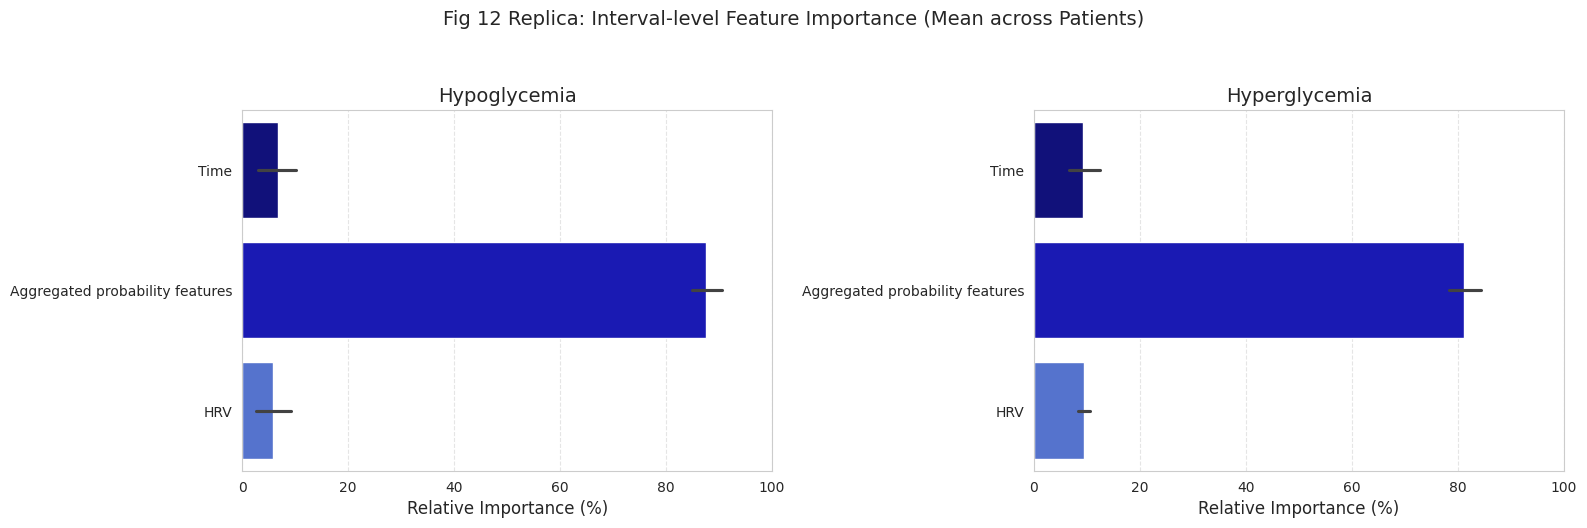

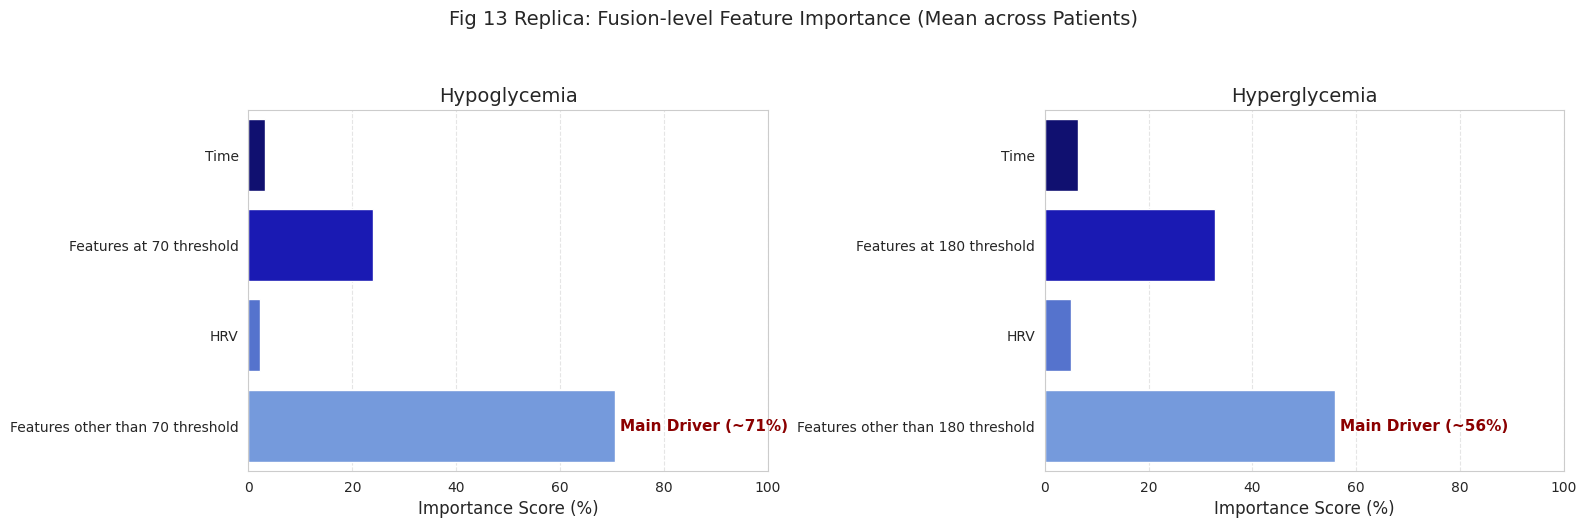

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

print("Generazione Grafici Importanza Variabili (Fig 12 & 13)...")

if 'feature_importance_storage' in globals() and feature_importance_storage:
    # 1. Unione di tutti i dati salvati
    all_imps = pd.concat(feature_importance_storage)
    
    # Normalizzazione a 100% per ogni soggetto
    all_imps['Importance_Pct'] = all_imps.groupby(['Subject', 'Task', 'Model'])['Importance'] \
                                         .transform(lambda x: 100 * x / x.sum())

    # --- DEFINIZIONE CATEGORIE ---
    def get_category_fig12(feat):
        if 'HRV' in feat: return 'HRV'
        if any(x in feat for x in ['hour', 'time']): return 'Time'
        return 'Aggregated probability features'

    def get_category_fig13(feat, task):
        std_thresh = '70' if task == 'Hypo' else '180'
        if 'HRV' in feat: return 'HRV'
        if any(x in feat for x in ['hour', 'time']): return 'Time'
        
        match = re.search(r'_(\d+)$', feat)
        if match:
            t_val = match.group(1)
            return f'Features at {std_thresh} threshold' if t_val == std_thresh else f'Features other than {std_thresh} threshold'
        return 'Other'

    # ==========================================
    # PLOT FIGURE 12 (M_Morph_HRV) - CORRETTO
    # ==========================================
    df_fig12 = all_imps[all_imps['Model'] == 'M_Morph_HRV'].copy()
    
    if not df_fig12.empty:
        df_fig12['Category'] = df_fig12['Feature'].apply(get_category_fig12)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        plt.suptitle("Fig 12 Replica: Interval-level Feature Importance (Mean across Patients)", fontsize=14, y=1.05)
        
        for i, task in enumerate(['Hypo', 'Hyper']):
            subset = df_fig12[df_fig12['Task'] == task]
            if subset.empty: continue
            
            # --- FIX: Aggrega per Soggetto PRIMA di fare la media ---
            # Calcoliamo quanto pesa ogni categoria per ogni singolo paziente (somma deve fare 100% per paziente)
            cat_sum = subset.groupby(['Subject', 'Category'])['Importance_Pct'].sum().reset_index()
            
            order = ['Time', 'Aggregated probability features', 'HRV']
            
            # Ora usiamo estimator=np.mean (default) per mostrare la media tra i pazienti
            sns.barplot(
                data=cat_sum, 
                x='Importance_Pct', 
                y='Category', 
                ax=axes[i], 
                estimator=np.mean,  # Media tra i pazienti (corretto!)
                errorbar=('ci', 95), # Mostra intervallo confidenza
                palette=['#00008b', '#0000cd', '#4169e1'], 
                order=order
            )
            
            axes[i].set_title(f"{task}glycemia")
            axes[i].set_xlabel("Relative Importance (%)")
            axes[i].set_xlim(0, 100) # Fissa asse a 100%
            axes[i].set_ylabel("")
            axes[i].grid(axis='x', linestyle='--', alpha=0.5)
            
        plt.tight_layout()
        plt.show()

    # ==========================================
    # PLOT FIGURE 13 (MF_Fusion) - INVARIATO (ERA GIÀ OK)
    # ==========================================
    df_fig13 = all_imps[all_imps['Model'] == 'MF_Fusion'].copy()
    
    if not df_fig13.empty:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        plt.suptitle("Fig 13 Replica: Fusion-level Feature Importance (Mean across Patients)", fontsize=14, y=1.05)
        
        for i, task in enumerate(['Hypo', 'Hyper']):
            subset = df_fig13[df_fig13['Task'] == task].copy()
            if subset.empty: continue
            
            subset['Category'] = subset['Feature'].apply(lambda x: get_category_fig13(x, task))
            std_t = '70' if task == 'Hypo' else '180'
            order = ['Time', f'Features at {std_t} threshold', 'HRV', f'Features other than {std_t} threshold']
            
            # Aggrega per soggetto
            cat_sum = subset.groupby(['Subject', 'Category'])['Importance_Pct'].sum().reset_index()
            
            sns.barplot(
                data=cat_sum, 
                x='Importance_Pct', 
                y='Category', 
                ax=axes[i], 
                estimator=np.mean, # Media tra pazienti
                errorbar=None, 
                order=order,
                palette=['navy', 'mediumblue', 'royalblue', 'cornflowerblue']
            )
            
            axes[i].set_title(f"{task}glycemia")
            axes[i].set_xlabel("Importance Score (%)")
            axes[i].set_xlim(0, 100)
            axes[i].set_ylabel("")
            axes[i].grid(axis='x', linestyle='--', alpha=0.5)

            # Annotazione Main Driver
            mean_vals = cat_sum.groupby('Category')['Importance_Pct'].mean()
            target_cat = f'Features other than {std_t} threshold'
            if target_cat in mean_vals:
                val = mean_vals[target_cat]
                axes[i].text(val + 1, 3, f"Main Driver (~{val:.0f}%)", va='center', fontweight='bold', color='darkred')

        plt.tight_layout()
        plt.show()
else:
    print("❌ Nessun dato di importanza trovato.")

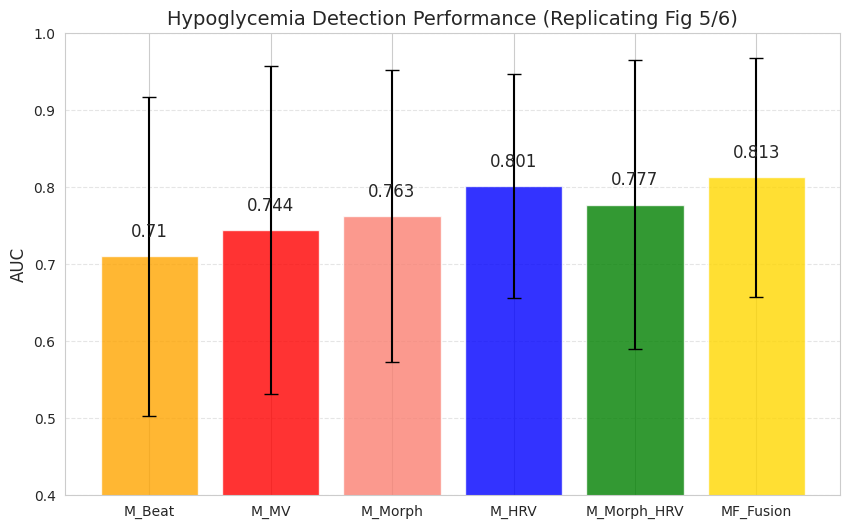

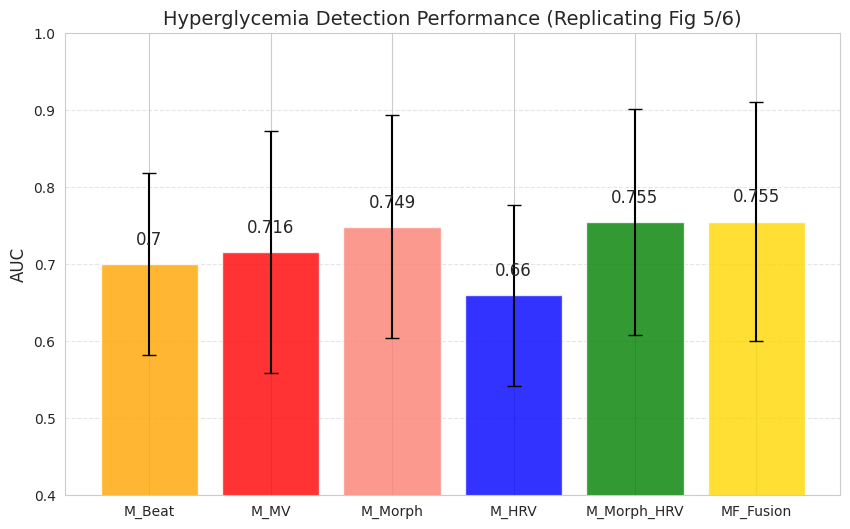

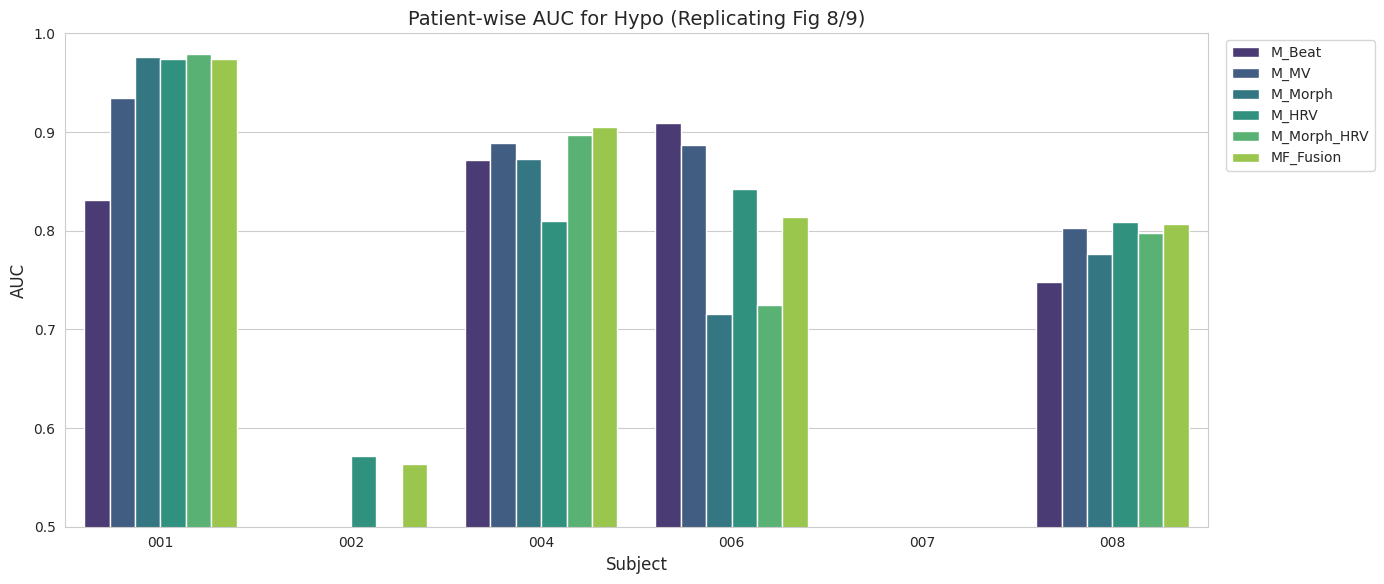

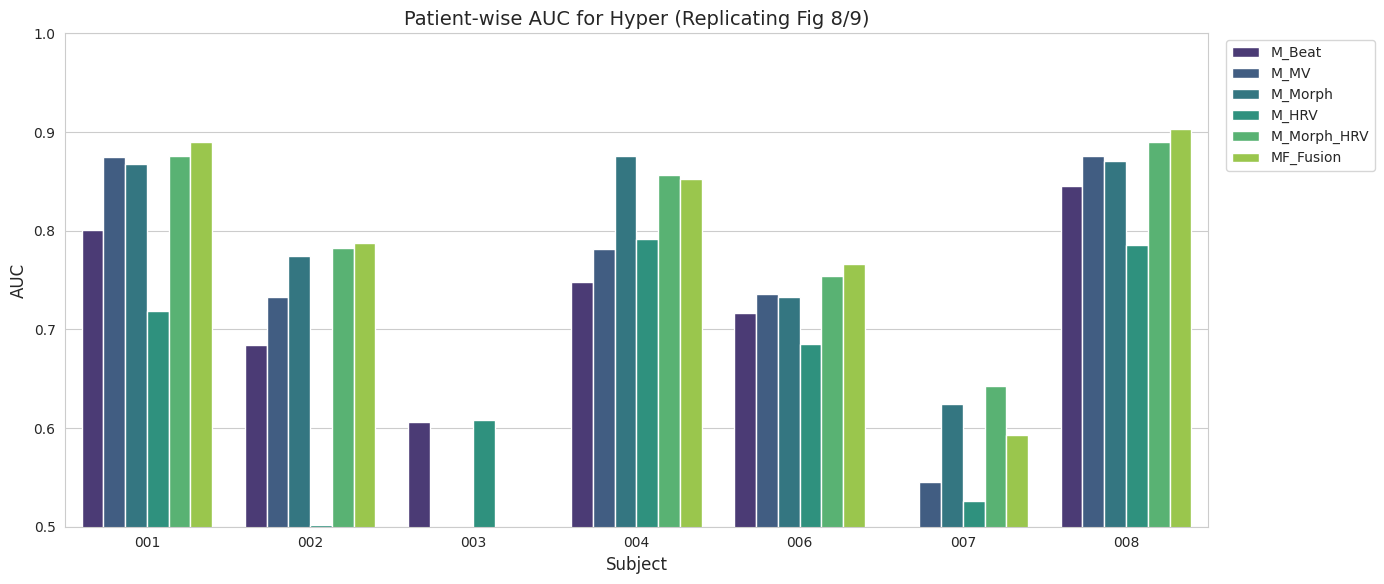

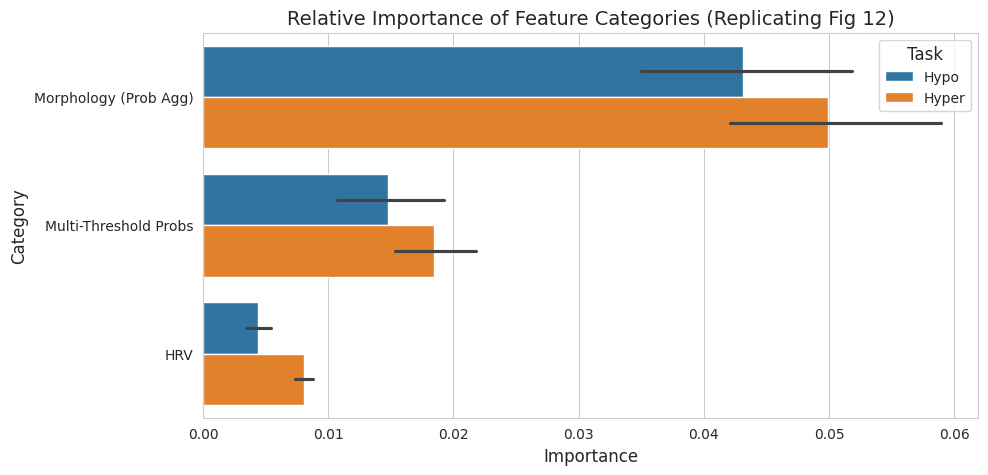

In [28]:
# ==========================================
# 7. VISUALIZATION & REPORTING
# ==========================================
import matplotlib.patches as mpatches

def plot_paper_figures(res_df):
    """Genera grafici simili a Fig 5, 6, 8, 9 del paper."""
    
    # --- FIG 5 & 6: Bar Plot Comparativo (Aggregato) ---
    for task in ['Hypo', 'Hyper']:
        plt.figure(figsize=(10, 6))
        subset = res_df[res_df['Task'] == task]
        
        # Ordine modelli come nel paper
        order = ['M_Beat', 'M_MV', 'M_Morph', 'M_HRV', 'M_Morph_HRV', 'MF_Fusion']
        # Nota: M_Beat puro non lo abbiamo salvato nell'array all_results allo stesso livello, 
        # ma M_Morph è il suo equivalente aggregato. Usiamo i disponibili.
        available = [o for o in order if o in subset['Model'].unique()]
        
        agg = subset.groupby('Model')['AUC'].agg(['mean', 'std']).reindex(available)
        
        colors = ['orange', 'red', 'salmon', 'blue', 'green', 'gold']
        bars = plt.bar(agg.index, agg['mean'], yerr=agg['std'], capsize=5, 
                       color=colors[:len(agg)], alpha=0.8)
        
        plt.ylim(0.4, 1.0)
        plt.title(f"{task}glycemia Detection Performance (Replicating Fig 5/6)")
        plt.ylabel("AUC")
        
        # Aggiungi etichette valori
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')
            
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

    # --- FIG 8 & 9: Patient-wise Performance ---
    for task in ['Hypo', 'Hyper']:
        plt.figure(figsize=(14, 6))
        subset = res_df[res_df['Task'] == task]
        
        sns.barplot(data=subset, x='Subject', y='AUC', hue='Model', palette='viridis')
        plt.ylim(0.5, 1.0)
        plt.title(f"Patient-wise AUC for {task} (Replicating Fig 8/9)")
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Esegui Plotting
if not df_results.empty:
    plot_paper_figures(df_results)

# --- FIG 12: Variable Importance (Simplified) ---
if feature_importance_storage:
    all_imps = pd.concat(feature_importance_storage)
    # Aggrega per categoria (HRV vs Morph vs Thresholds)
    def categorize(name):
        if 'HRV' in name: return 'HRV'
        if 'p_' in name: return 'Multi-Threshold Probs'
        return 'Morphology (Prob Agg)'
        
    all_imps['Category'] = all_imps['Feature'].apply(categorize)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=all_imps, x='Importance', y='Category', hue='Task', estimator=np.mean)
    plt.title("Relative Importance of Feature Categories (Replicating Fig 12)")
    plt.show()

In [29]:
# ==========================================
# 8. FINAL TABLE GENERATION
# ==========================================
pivot_table = df_results.groupby(['Task', 'Model'])['AUC'].agg(['mean', 'std']).unstack(0)

# Formattazione "Mean ± Std"
def fmt(x):
    return f"{x['mean']:.3f} ± {x['std']:.3f}"

# Applicazione per ogni task
summary = pd.DataFrame()
for task in ['Hypo', 'Hyper']:
    temp = df_results[df_results['Task'] == task].groupby('Model')['AUC'].agg(['mean', 'std'])
    summary[task] = temp.apply(fmt, axis=1)

print("\n=== TABELLA 3 REPLICA (Performance Summary) ===")
display(summary)


=== TABELLA 3 REPLICA (Performance Summary) ===


,Hypo,Hyper
Model,,
MF_Fusion,0.813 ± 0.155,0.755 ± 0.156
M_Beat,0.710 ± 0.207,0.700 ± 0.118
M_HRV,0.801 ± 0.145,0.660 ± 0.118
M_MV,0.744 ± 0.213,0.716 ± 0.157
M_Morph,0.763 ± 0.189,0.749 ± 0.145
M_Morph_HRV,0.777 ± 0.188,0.755 ± 0.147



=== GENERAZIONE REPORT GRAFICO COMPLETO ===
Generazione Fig. 16 (Thresholds)...


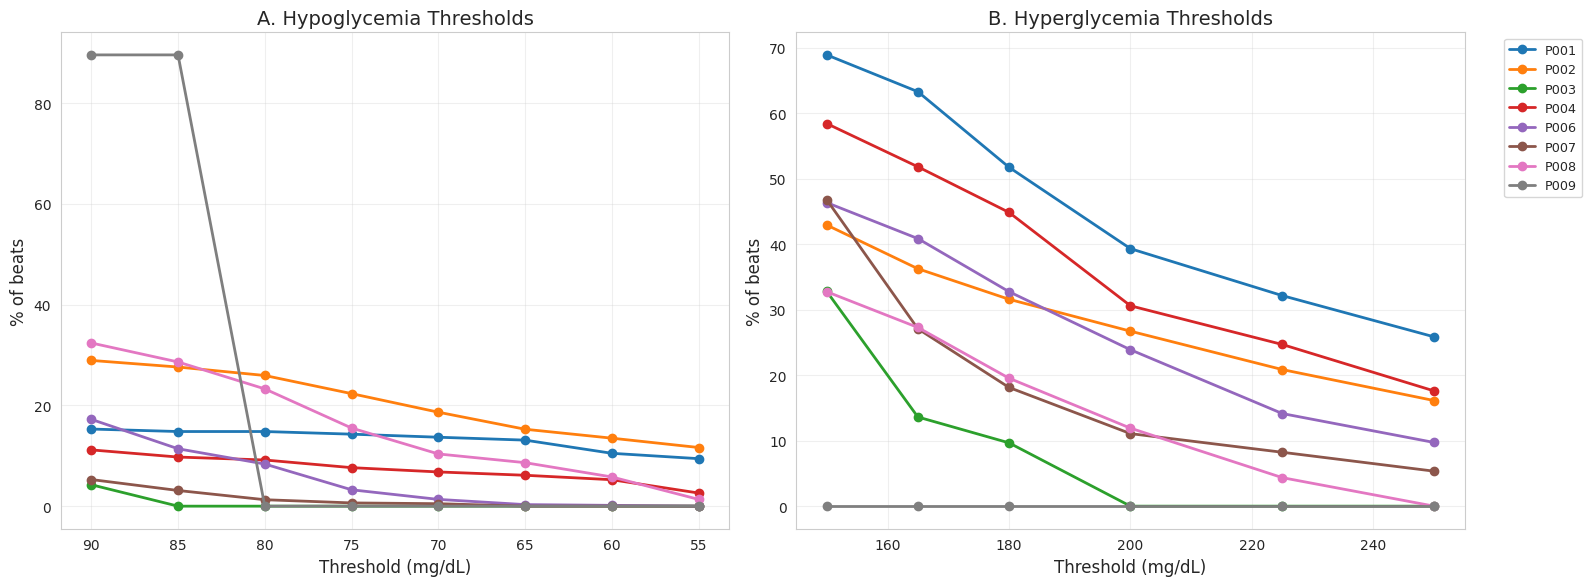

Generazione Heatmap Significatività...


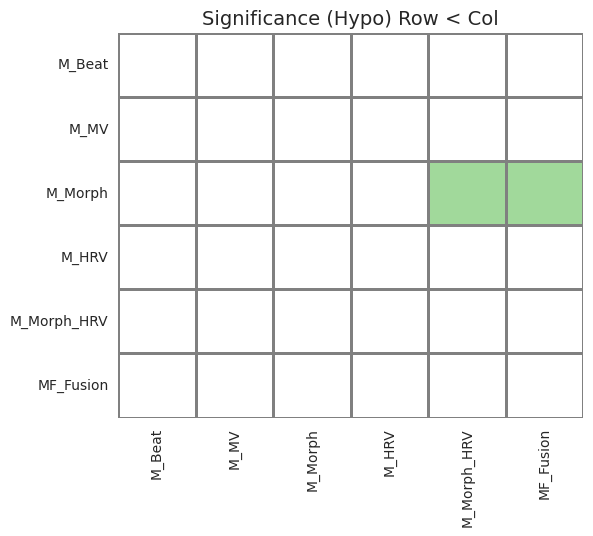

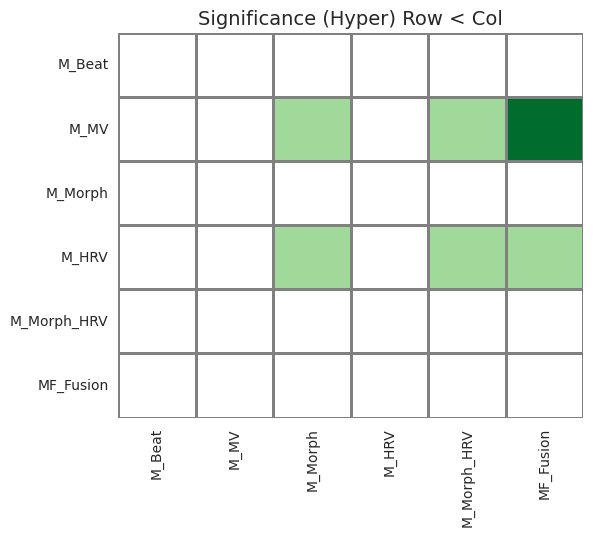

Generazione Fig. 14 (Boxplots)...


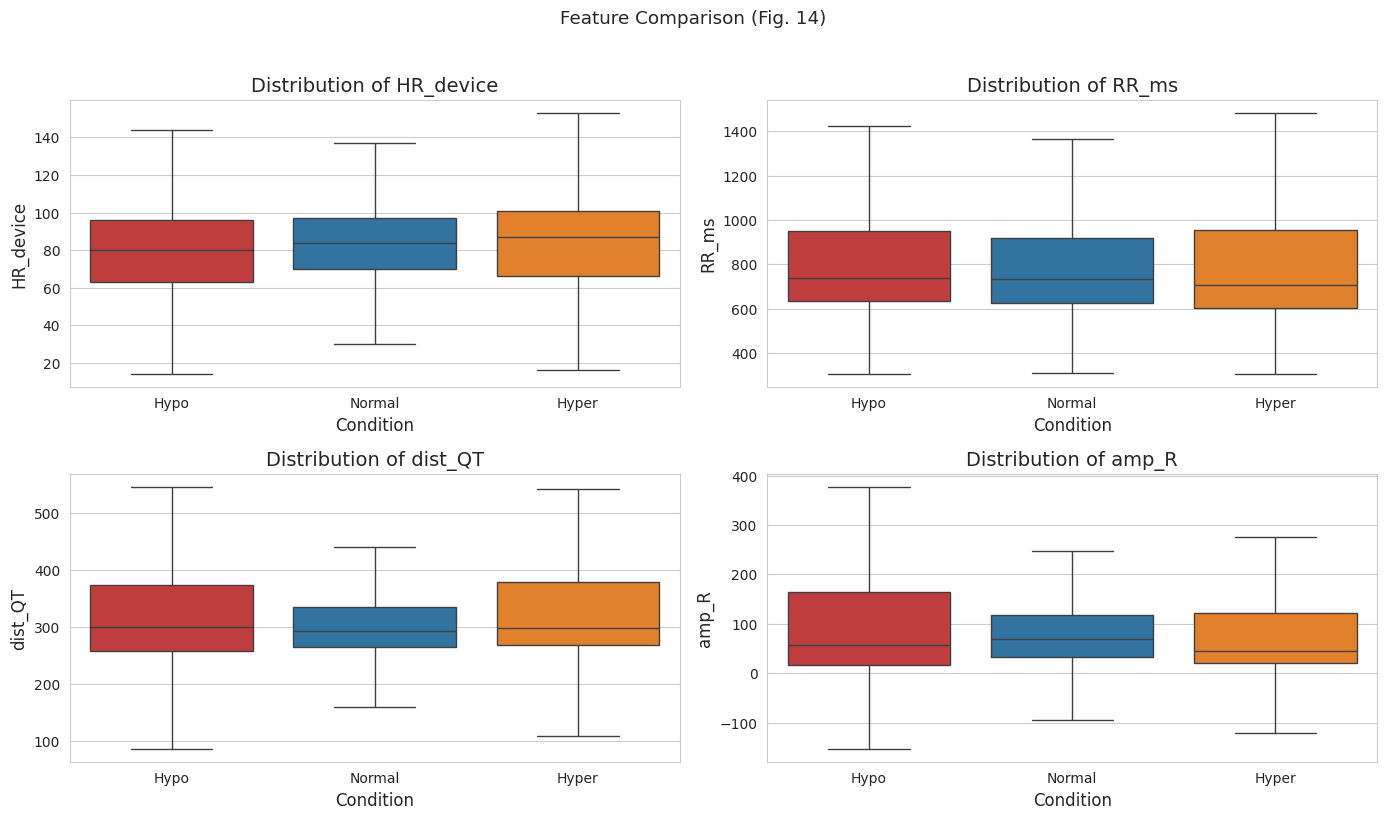


--- PAZIENTE HYPO: 002 ---


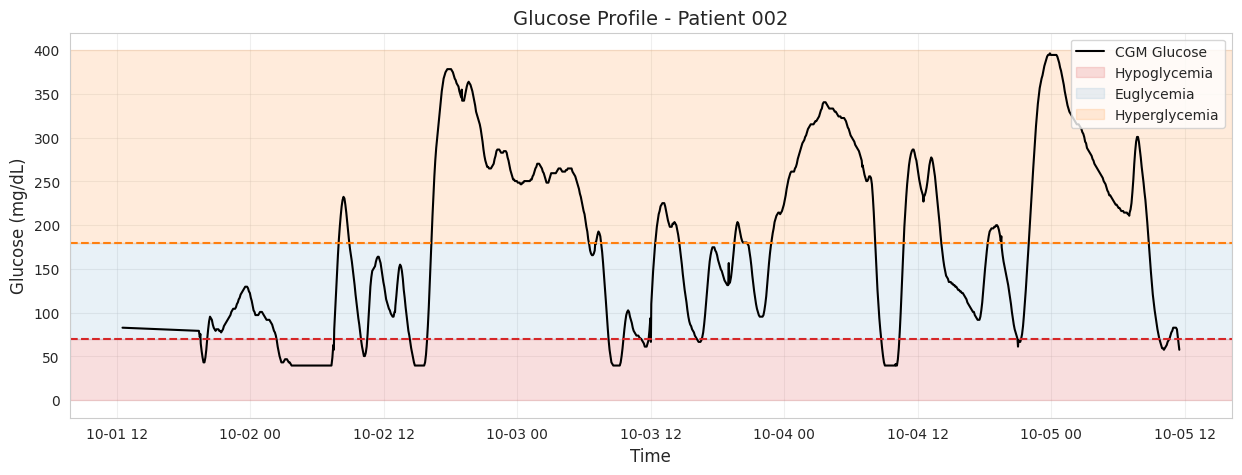

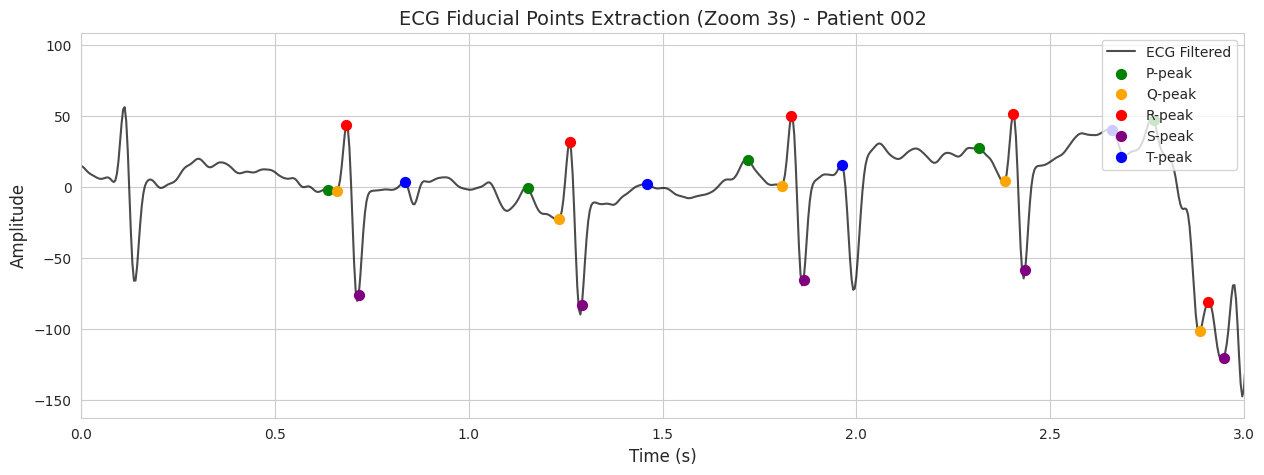

Generazione Plot Morfologico: Hypo vs Normal (Patient 002)...


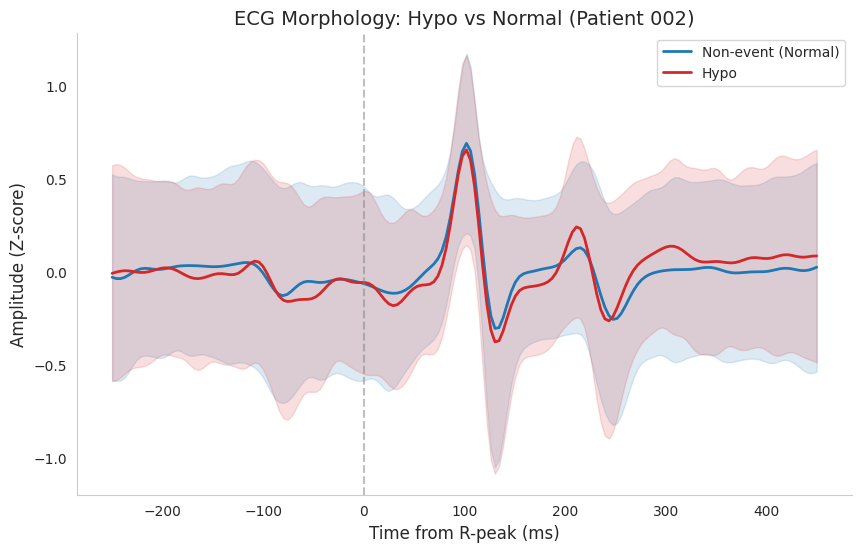

Generazione Plot Morfologico: Hyper vs Normal (Patient 002)...


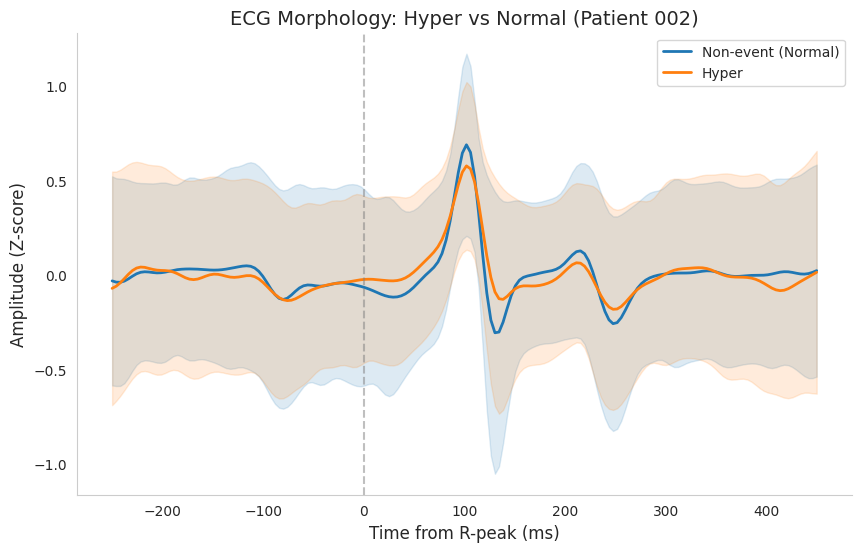

In [30]:
# ==========================================
# 9. SCIENTIFIC VISUALIZATION (FULL PAPER REPLICA - FINAL VERSION)
# ==========================================
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

print("\n=== GENERAZIONE REPORT GRAFICO COMPLETO ===")

# Configurazione Stile
plt.rcParams.update({'font.size': 11, 'figure.figsize': (12, 6)})
PALETTE = {"Hypo": "#d62728", "Normal": "#1f77b4", "Hyper": "#ff7f0e"} # Rosso, Blu, Arancio

def get_patient_data(subj_id):
    row = df_index[df_index['subject'] == subj_id].iloc[0]
    return row

# --- 1. PROFILO GLUCOSIO ---
def plot_glucose_profile(subj_id):
    row = get_patient_data(subj_id)
    df_gluc = load_glucose_clean(row['gluc_path'])
    if df_gluc is None: return
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_gluc['Time'], df_gluc['Glucose'], color='black', linewidth=1.5, label='CGM Glucose')
    
    # Zone
    plt.axhspan(0, HYPO_LIMIT, color=PALETTE['Hypo'], alpha=0.15, label='Hypoglycemia')
    plt.axhspan(HYPO_LIMIT, HYPER_LIMIT, color=PALETTE['Normal'], alpha=0.1, label='Euglycemia')
    plt.axhspan(HYPER_LIMIT, 400, color=PALETTE['Hyper'], alpha=0.15, label='Hyperglycemia')
    
    plt.axhline(HYPO_LIMIT, color=PALETTE['Hypo'], linestyle='--')
    plt.axhline(HYPER_LIMIT, color=PALETTE['Hyper'], linestyle='--')
    
    plt.title(f"Glucose Profile - Patient {subj_id}")
    plt.ylabel("Glucose (mg/dL)"); plt.xlabel("Time")
    plt.legend(loc='upper right'); plt.grid(True, alpha=0.3)
    plt.show()

# --- 2. DELINEAZIONE ECG (Fix 6s buffer) ---
def plot_ecg_delineation(subj_id, window_sec=3):
    row = get_patient_data(subj_id)
    sig_raw, times, hrc, _ = load_ecg_hrc(row['ecg_path'], row['sum_path'])
    if sig_raw is None: return

    sig = nk.ecg_clean(sig_raw, sampling_rate=FS, method="neurokit")
    mid = len(sig) // 2
    if len(hrc) > 0:
        high_qual_idx = np.where(hrc > 95)[0]
        if len(high_qual_idx) > 0: mid = high_qual_idx[len(high_qual_idx)//2] * FS 
            
    # Buffer minimo di 6s per NeuroKit
    process_duration = max(window_sec, 6) 
    start = int(mid)
    end = start + int(process_duration * FS)
    if end > len(sig): end = len(sig); start = max(0, end - int(process_duration * FS))
    
    segment = sig[start:end]
    if len(segment) < 4 * FS: return
    
    try:
        _, rpeaks = nk.ecg_peaks(segment, sampling_rate=FS)
        _, waves = nk.ecg_delineate(segment, rpeaks, sampling_rate=FS, method='peak')
    except: return
    
    plt.figure(figsize=(15, 5))
    time_axis = np.arange(len(segment))/FS
    plt.plot(time_axis, segment, color='black', alpha=0.7, label='ECG Filtered')
    
    for peak_type, color in zip(['P', 'Q', 'R', 'S', 'T'], ['green', 'orange', 'red', 'purple', 'blue']):
        pk_idxs = waves.get(f'ECG_{peak_type}_Peaks', [])
        if peak_type == 'R': pk_idxs = rpeaks['ECG_R_Peaks']
        pk_idxs = [x for x in pk_idxs if not np.isnan(x)]
        if len(pk_idxs) > 0:
            y_vals = segment[np.array(pk_idxs).astype(int)]
            plt.scatter(np.array(pk_idxs)/FS, y_vals, color=color, s=50, zorder=5, label=f'{peak_type}-peak')

    plt.title(f"ECG Fiducial Points Extraction (Zoom {window_sec}s) - Patient {subj_id}")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.xlim(0, window_sec) 
    plt.legend(loc='upper right'); plt.show()

# --- 3. MORFOLOGIA MEDIA (OTTIMIZZATA: Z-Score + Allineamento) ---
def plot_morphology_comparison(subj_id, target_condition='Hypo'):
    """
    Genera confronto morfologico tra 'target_condition' (Hypo o Hyper) e 'Normal'.
    Usa normalizzazione Z-score e ri-allineamento dei picchi per evitare linee piatte.
    """
    pat_beats = beats_df_clean[beats_df_clean['subject'] == subj_id].copy()
    if pat_beats.empty: return

    # Classi
    pat_beats['Condition'] = 'Normal'
    pat_beats.loc[pat_beats['Glucose'] < HYPO_LIMIT, 'Condition'] = 'Hypo'
    pat_beats.loc[pat_beats['Glucose'] > HYPER_LIMIT, 'Condition'] = 'Hyper'

    # Check dati
    n_events = len(pat_beats[pat_beats['Condition'] == target_condition])
    if n_events < 10:
        print(f"Skipping {target_condition} plot for Patient {subj_id}: Not enough events ({n_events})")
        return

    print(f"Generazione Plot Morfologico: {target_condition} vs Normal (Patient {subj_id})...")
    
    # Caricamento
    row = get_patient_data(subj_id)
    sig_raw, _, _, _ = load_ecg_hrc(row['ecg_path'], row['sum_path'])
    sig = nk.ecg_clean(sig_raw, sampling_rate=FS, method="neurokit")

    # Finestra: -250ms a +450ms
    before = int(0.25 * FS); after = int(0.45 * FS)
    epochs = {target_condition: [], 'Normal': []}
    
    for cond in [target_condition, 'Normal']:
        indices = pat_beats[pat_beats['Condition'] == cond]['rpeak_idx'].values
        # Limitiamo a 800 beat per pulizia e velocità
        if len(indices) > 800:
            np.random.seed(42)
            indices = np.random.choice(indices, 800, replace=False)
            
        for r_idx in indices:
            if r_idx - before < 0 or r_idx + after >= len(sig): continue
            
            # 1. Estrai
            seg = sig[r_idx - before : r_idx + after]
            
            # 2. Re-Align (Cerca max locale per centrare R)
            center_w = 10
            mid_pt = len(seg)//2
            search = seg[mid_pt - center_w : mid_pt + center_w]
            if len(search) == 0: continue
            shift = np.argmax(search) - center_w
            
            if abs(shift) > 0:
                new_r = r_idx + shift
                if new_r - before < 0 or new_r + after >= len(sig): continue
                seg = sig[new_r - before : new_r + after]

            # 3. Z-Score Normalize (Cruciale per visualizzazione)
            if np.std(seg) == 0: continue
            seg_norm = (seg - np.mean(seg)) / np.std(seg)
            
            # Outlier filter
            if np.max(np.abs(seg_norm)) < 10:
                epochs[cond].append(seg_norm)

    # Plot
    time_axis = np.linspace(-250, 450, before + after)
    plt.figure(figsize=(10, 6))
    
    # Plot Normal (Blu)
    if epochs['Normal']:
        arr = np.array(epochs['Normal'])
        mean_n = np.mean(arr, axis=0)
        std_n = np.std(arr, axis=0)
        plt.plot(time_axis, mean_n, color=PALETTE['Normal'], label='Non-event (Normal)', linewidth=2)
        plt.fill_between(time_axis, mean_n - 0.5*std_n, mean_n + 0.5*std_n, color=PALETTE['Normal'], alpha=0.15)

    # Plot Event (Rosso/Arancio)
    color_ev = PALETTE[target_condition]
    if epochs[target_condition]:
        arr = np.array(epochs[target_condition])
        mean_e = np.mean(arr, axis=0)
        std_e = np.std(arr, axis=0)
        plt.plot(time_axis, mean_e, color=color_ev, label=target_condition, linewidth=2)
        plt.fill_between(time_axis, mean_e - 0.5*std_e, mean_e + 0.5*std_e, color=color_ev, alpha=0.15)

    plt.title(f"ECG Morphology: {target_condition} vs Normal (Patient {subj_id})")
    plt.xlabel("Time from R-peak (ms)"); plt.ylabel("Amplitude (Z-score)")
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.legend(); plt.grid(False); sns.despine()
    plt.show()

# --- 4. BOXPLOTS FIG 14 ---
def plot_feature_boxplots_fig14():
    print("Generazione Fig. 14 (Boxplots)...")
    plot_df = beats_df_clean.sample(n=min(15000, len(beats_df_clean)), random_state=42).copy()
    plot_df['Condition'] = 'Normal'
    plot_df.loc[plot_df['Glucose'] < HYPO_LIMIT, 'Condition'] = 'Hypo'
    plot_df.loc[plot_df['Glucose'] > HYPER_LIMIT, 'Condition'] = 'Hyper'
    
    order = ['Hypo', 'Normal', 'Hyper']
    target_feats = ['HR_device', 'RR_ms', 'dist_QT', 'amp_R']
    valid_feats = [f for f in target_feats if f in plot_df.columns]
    
    if not valid_feats: return
    plt.figure(figsize=(14, 8))
    for i, feat in enumerate(valid_feats):
        plt.subplot(2, 2, i+1)
        sns.boxplot(data=plot_df, x='Condition', y=feat, order=order, palette=PALETTE, showfliers=False)
        plt.title(f"Distribution of {feat}")
    plt.suptitle("Feature Comparison (Fig. 14)", y=1.02); plt.tight_layout(); plt.show()

# --- 5. EVENTS vs THRESHOLD FIG 16 ---
def plot_fig16_varying_thresholds():
    print("Generazione Fig. 16 (Thresholds)...")
    hypo_t = THRESHOLDS_FUSION['Hypo']
    hyper_t = THRESHOLDS_FUSION['Hyper']
    subjects = beats_df_clean['subject'].unique()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    for sub in subjects:
        sub_df = beats_df_clean[beats_df_clean['subject'] == sub]
        if len(sub_df) == 0: continue
        
        # Hypo
        pcts_h = [(len(sub_df[sub_df['Glucose'] < t]) / len(sub_df))*100 for t in hypo_t]
        ax1.plot(hypo_t, pcts_h, 'o-', linewidth=2, label=f'P{sub}')
        
        # Hyper
        pcts_H = [(len(sub_df[sub_df['Glucose'] > t]) / len(sub_df))*100 for t in hyper_t]
        ax2.plot(hyper_t, pcts_H, 'o-', linewidth=2, label=f'P{sub}')

    ax1.set_title("A. Hypoglycemia Thresholds"); ax1.set_xlabel("Threshold (mg/dL)"); ax1.invert_xaxis()
    ax1.set_ylabel("% of beats"); ax1.grid(True, alpha=0.3)
    
    ax2.set_title("B. Hyperglycemia Thresholds"); ax2.set_xlabel("Threshold (mg/dL)")
    ax2.set_ylabel("% of beats"); ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# --- 6. HEATMAP SIGNIFICATIVITÀ ---
def plot_significance_heatmap(results_df):
    print("Generazione Heatmap Significatività...")
    if results_df.empty: return
    pivot = results_df.groupby(['Subject', 'Task', 'Model'])['AUC'].mean().reset_index()
    tasks = ['Hypo', 'Hyper']
    models_order = ['M_Beat', 'M_MV', 'M_Morph', 'M_HRV', 'M_Morph_HRV', 'MF_Fusion']
    available = [m for m in models_order if m in pivot['Model'].unique()]
    cmap = ListedColormap(['#ffffff', '#a1d99b', '#31a354', '#006d2c']) 

    for task in tasks:
        t_data = pivot[pivot['Task'] == task]
        if t_data.empty: continue
        p_matrix = np.zeros((len(available), len(available)))
        
        for i, m1 in enumerate(available):
            for j, m2 in enumerate(available):
                if i == j: continue
                s1 = t_data[t_data['Model'] == m1].sort_values('Subject')['AUC'].values
                s2 = t_data[t_data['Model'] == m2].sort_values('Subject')['AUC'].values
                if len(s1)>1 and len(s1)==len(s2):
                    _, p = stats.ttest_rel(s1, s2)
                    val = p/2 if np.mean(s2) > np.mean(s1) else 1.0
                    if val < 0.001: score = 3.5
                    elif val < 0.01: score = 2.5
                    elif val < 0.05: score = 1.5
                    else: score = 0.5
                    p_matrix[i, j] = score

        plt.figure(figsize=(6, 5))
        sns.heatmap(p_matrix, cmap=cmap, linewidths=1, linecolor='gray', 
                    xticklabels=available, yticklabels=available, cbar=False, vmin=0, vmax=4)
        plt.title(f"Significance ({task}) Row < Col")
        plt.show()

# === ESECUZIONE ===
if not beats_df_clean.empty and not df_results.empty:
    
    # 1. Figure di Popolazione
    plot_fig16_varying_thresholds()
    plot_significance_heatmap(df_results)
    plot_feature_boxplots_fig14()
    
    # 2. Dettagli Paziente (Morfologia e Segnali)
    # Cerchiamo il miglior candidato per Hypo
    hypo_counts = beats_df_clean[beats_df_clean['Glucose'] < 70].groupby('subject').size()
    best_hypo_subj = hypo_counts.idxmax() if not hypo_counts.empty else beats_df_clean['subject'].iloc[0]
    
    print(f"\n--- PAZIENTE HYPO: {best_hypo_subj} ---")
    plot_glucose_profile(best_hypo_subj)
    plot_ecg_delineation(best_hypo_subj, window_sec=3)
    plot_morphology_comparison(best_hypo_subj, target_condition='Hypo')
    
    # Cerchiamo il miglior candidato per Hyper (potrebbe essere lo stesso o diverso)
    hyper_counts = beats_df_clean[beats_df_clean['Glucose'] > 180].groupby('subject').size()
    best_hyper_subj = hyper_counts.idxmax() if not hyper_counts.empty else best_hypo_subj
    
    if best_hyper_subj != best_hypo_subj:
        print(f"\n--- PAZIENTE HYPER: {best_hyper_subj} ---")
        # Se è diverso, mostra profilo anche di lui
        plot_glucose_profile(best_hyper_subj) 
        
    plot_morphology_comparison(best_hyper_subj, target_condition='Hyper')

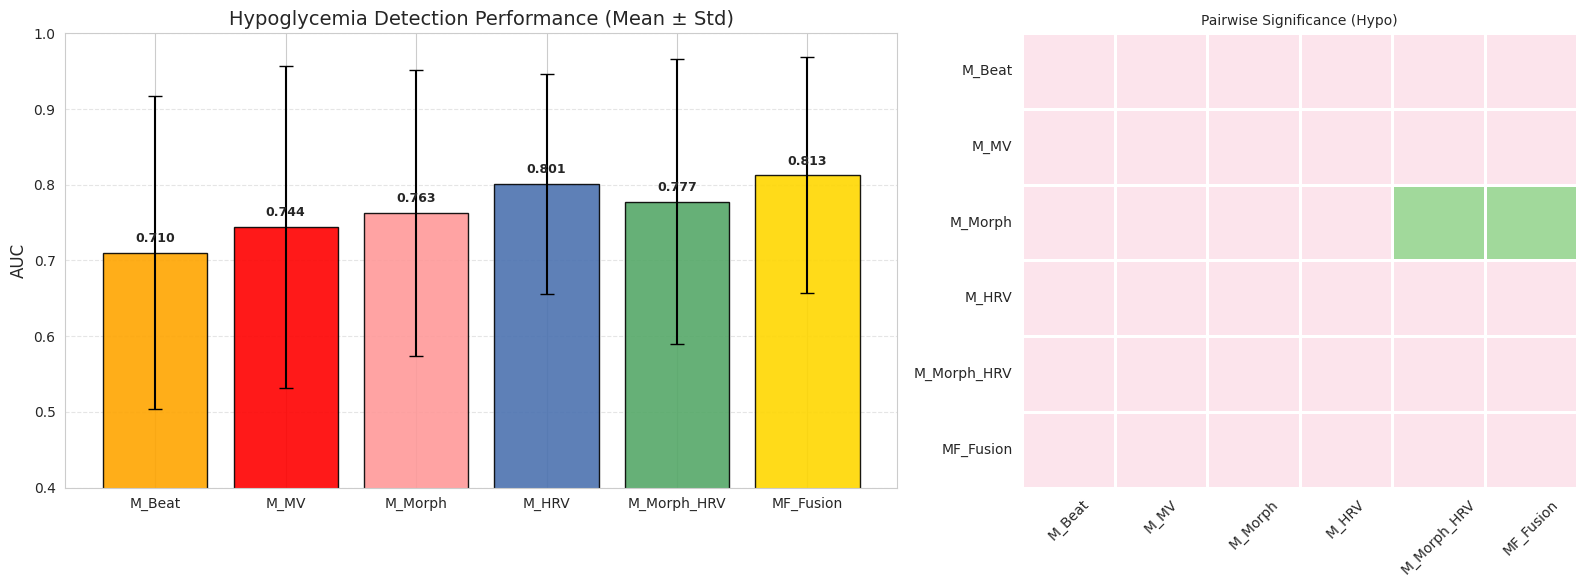

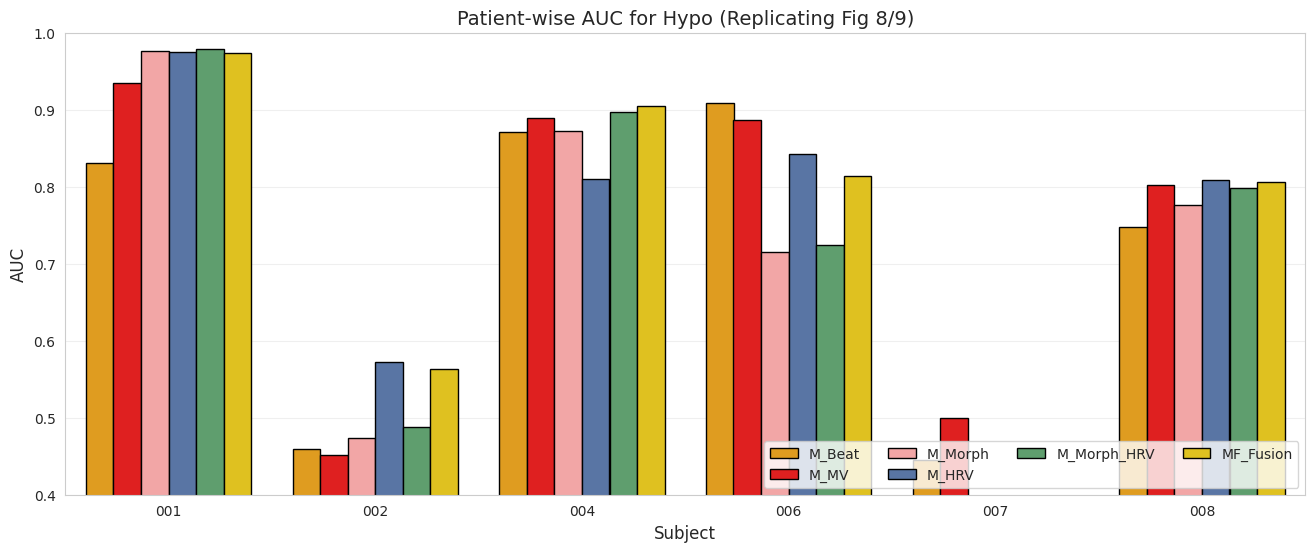

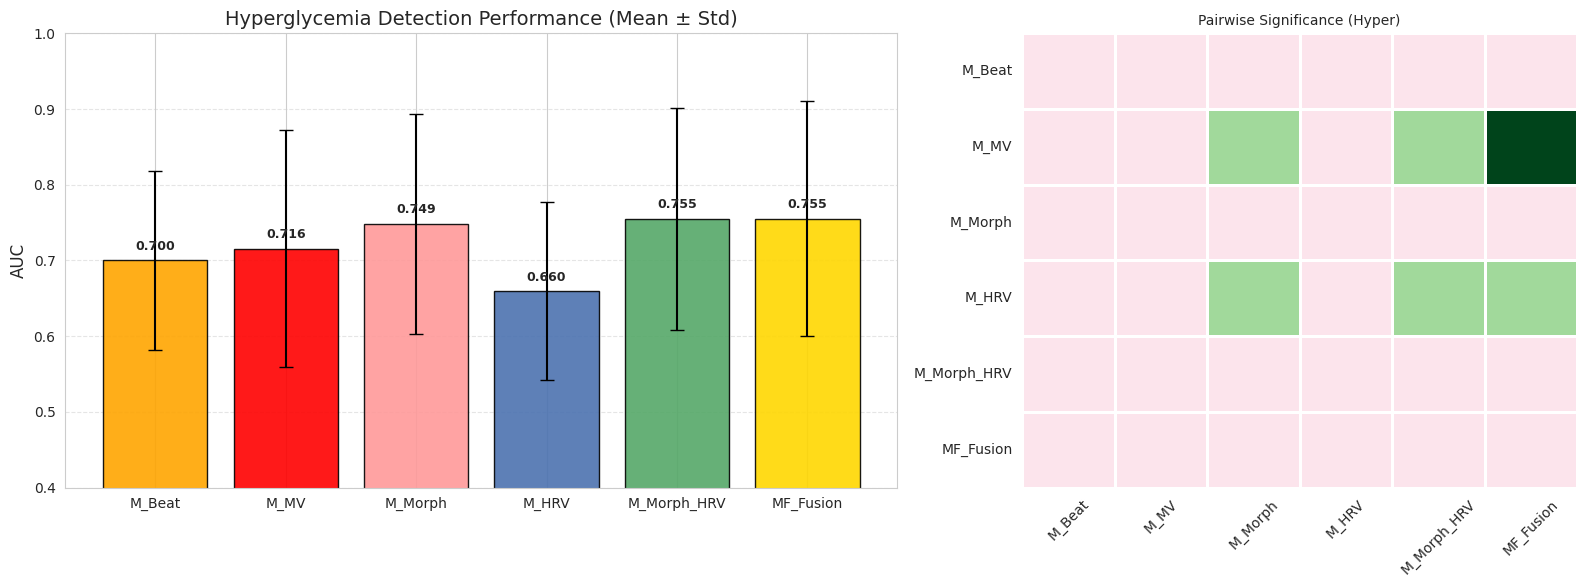

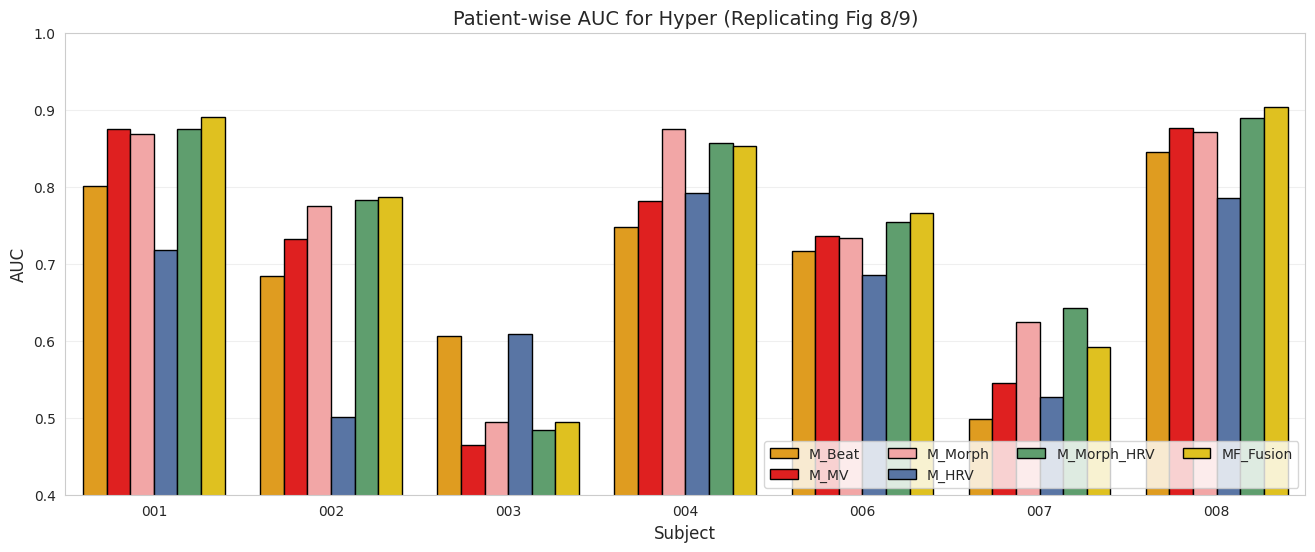

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.colors import ListedColormap

# --- DEFINIZIONE PALETTE COMPLETA (FORZATA) ---
# Definiamo sempre la palette completa per evitare errori di chiavi mancanti
PALETTE = {
    "Hypo": "#d62728", 
    "Normal": "#1f77b4", 
    "Hyper": "#ff7f0e",
    "M_Beat": "orange", 
    "M_MV": "red", 
    "M_Morph": "#ff9999",       # Salmon
    "M_HRV": "#4c72b0",         # Blue
    "M_Morph_HRV": "#55a868",   # Green
    "MF_Fusion": "#ffd700"      # Gold
}

def plot_significance_heatmap(task, results_df, ax):
    """Genera la heatmap dei p-value gestendo pazienti mancanti."""
    t_data = results_df[results_df['Task'] == task]
    
    # Ordine preferito per la visualizzazione
    desired_order = ['M_Beat', 'M_MV', 'M_Morph', 'M_HRV', 'M_Morph_HRV', 'MF_Fusion']
    models = [m for m in desired_order if m in t_data['Model'].unique()]
    
    p_matrix = np.zeros((len(models), len(models)))
    
    # Calcolo t-test a coppie
    for i, m1 in enumerate(models):
        for j, m2 in enumerate(models):
            if i == j: continue
            
            # --- FIX: ALLINEAMENTO SOGGETTI ---
            df1 = t_data[t_data['Model'] == m1].set_index('Subject')['AUC']
            df2 = t_data[t_data['Model'] == m2].set_index('Subject')['AUC']
            
            # Intersezione soggetti
            common_subjects = df1.index.intersection(df2.index)
            
            if len(common_subjects) < 2:
                continue
                
            s1 = df1.loc[common_subjects].values
            s2 = df2.loc[common_subjects].values
            # ----------------------------------
            
            # One-tailed t-test (Row < Col ?)
            try:
                _, p = stats.ttest_rel(s1, s2)
                val = p/2 if np.mean(s2) > np.mean(s1) else 1.0
                
                if val < 0.001: score = 3
                elif val < 0.01: score = 2
                elif val < 0.05: score = 1
                else: score = 0 
                
                p_matrix[i, j] = score
            except:
                p_matrix[i, j] = 0

    # Plot Heatmap
    cmap = ListedColormap(['#fce4ec', '#a1d99b', '#31a354', '#00441b']) 
    sns.heatmap(p_matrix, cmap=cmap, linewidths=1, linecolor='white', 
                xticklabels=models, yticklabels=models, cbar=False, ax=ax, vmin=0, vmax=3)
    
    ax.set_title(f"Pairwise Significance ({task})", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# --- PLOTTING ---
if 'df_results' in globals() and not df_results.empty:
    for task in ['Hypo', 'Hyper']:
        subset = df_results[df_results['Task'] == task]
        if subset.empty: continue

        # --- FIG 5 & 6 (Aggregato + Significance) ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1.5, 1]})
        
        order = ['M_Beat', 'M_MV', 'M_Morph', 'M_HRV', 'M_Morph_HRV', 'MF_Fusion']
        avail = [o for o in order if o in subset['Model'].unique()]
        
        # Bar Plot
        agg = subset.groupby('Model')['AUC'].agg(['mean', 'std']).reindex(avail)
        colors = [PALETTE.get(m, 'grey') for m in avail]
        
        bars = ax1.bar(agg.index, agg['mean'], yerr=agg['std'], capsize=5, color=colors, alpha=0.9, edgecolor='black')
        ax1.set_ylim(0.4, 1.0)
        ax1.set_ylabel("AUC")
        ax1.set_title(f"{task}glycemia Detection Performance (Mean ± Std)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, 
                     f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

        # Heatmap
        plot_significance_heatmap(task, df_results, ax2)
        plt.tight_layout()
        plt.show()

        # --- FIG 8 & 9 (Patient-wise) ---
        plt.figure(figsize=(16, 6))
        sns.barplot(data=subset, x='Subject', y='AUC', hue='Model', 
                    palette=PALETTE, edgecolor='black', hue_order=avail)
        
        plt.ylim(0.4, 1.0)
        plt.title(f"Patient-wise AUC for {task} (Replicating Fig 8/9)")
        plt.legend(loc='lower right', ncol=len(avail)//2 + 1)
        plt.grid(axis='y', alpha=0.3)
        plt.show()
else:
    print("⚠️ Nessun dato in df_results.")


=== REPLICA FIG 15 (Misclassification by Range) ===


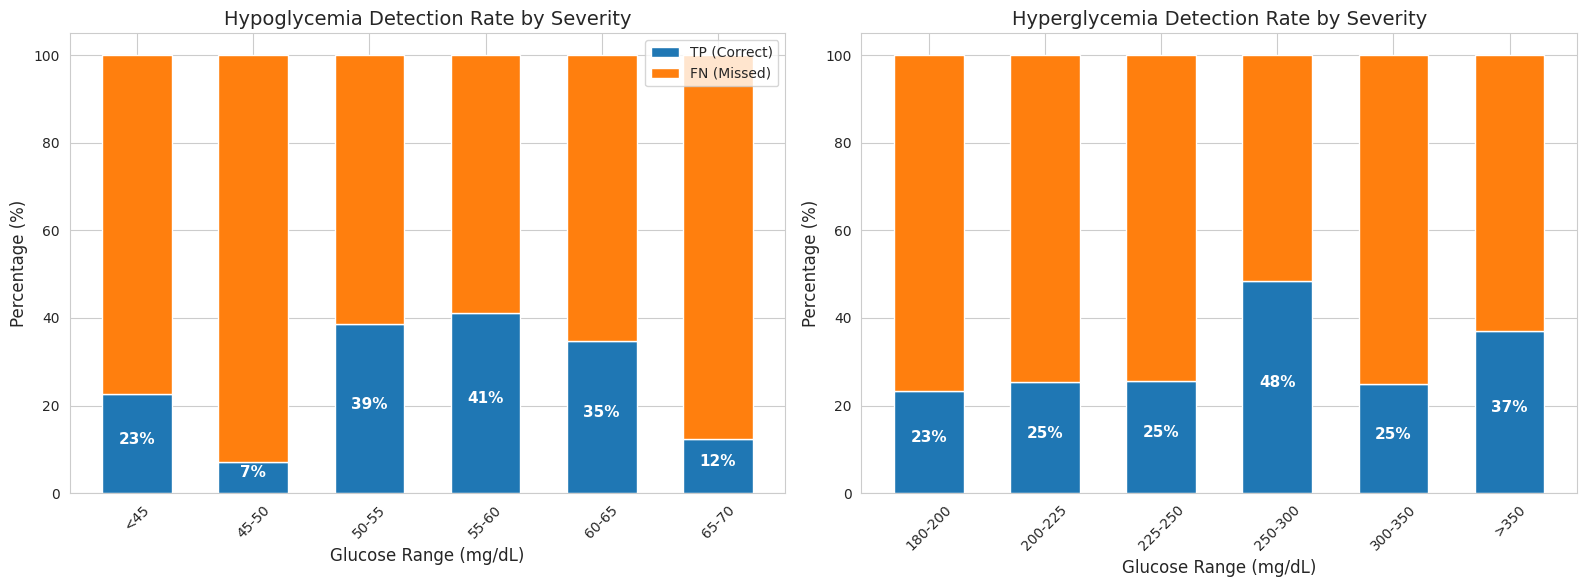

In [33]:
def plot_fig15_misclassification_by_range():
    print("\n=== REPLICA FIG 15 (Misclassification by Range) ===")
    
    # 1. Preparazione Dati (Simuliamo un test set aggregato)
    # Usiamo il modello M_Morph_HRV (più veloce del Fusion per questa demo)
    # per calcolare le predizioni su tutto il dataset pulito.
    
    from sklearn.model_selection import cross_val_predict
    from sklearn.ensemble import RandomForestClassifier
    
    df = df_int_clean.copy()
    features = [c for c in df.columns if c.startswith(('mean_', 'HRV_', 'hour_'))]
    
    # Range Glucosio (Bucket)
    bins_hypo = [0, 45, 50, 55, 60, 65, 70]
    labels_hypo = ['<45', '45-50', '50-55', '55-60', '60-65', '65-70']
    
    bins_hyper = [180, 200, 225, 250, 300, 350, 500]
    labels_hyper = ['180-200', '200-225', '225-250', '250-300', '300-350', '>350']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, (task, bins, labels) in enumerate(zip(['Hypo', 'Hyper'], [bins_hypo, bins_hyper], [labels_hypo, labels_hyper])):
        
        limit = HYPO_LIMIT if task == 'Hypo' else HYPER_LIMIT
        op = (lambda x: x < limit) if task == 'Hypo' else (lambda x: x > limit)
        y = op(df['glucose']).astype(int)
        
        # Cross-validation rapida (3-fold) per avere predizioni out-of-sample
        clf = RandomForestClassifier(n_estimators=50, max_depth=8, class_weight='balanced', n_jobs=-1, random_state=42)
        
        try:
            # Predizioni
            preds = cross_val_predict(clf, df[features].fillna(0), y, cv=3, method='predict')
            df['pred'] = preds
            df['true'] = y
            
            # Filtra solo i veri positivi (Eventi reali)
            events = df[df['true'] == 1].copy()
            events['range'] = pd.cut(events['glucose'], bins=bins, labels=labels)
            
            # Calcola TP e FN per bin
            stats_df = events.groupby('range').apply(
                lambda x: pd.Series({
                    'TP': (x['pred'] == 1).sum(),
                    'FN': (x['pred'] == 0).sum(),
                    'Total': len(x)
                })
            ).reset_index()
            
            # Calcolo Percentuali
            stats_df['TP_pct'] = (stats_df['TP'] / stats_df['Total']) * 100
            stats_df['FN_pct'] = (stats_df['FN'] / stats_df['Total']) * 100
            
            # Plot Stacked Bar
            ax = axes[i]
            x = np.arange(len(stats_df))
            width = 0.6
            
            ax.bar(x, stats_df['TP_pct'], width, label='TP (Correct)', color='#1f77b4')
            ax.bar(x, stats_df['FN_pct'], width, bottom=stats_df['TP_pct'], label='FN (Missed)', color='#ff7f0e')
            
            ax.set_xticks(x)
            ax.set_xticklabels(stats_df['range'], rotation=45)
            ax.set_title(f"{task}glycemia Detection Rate by Severity")
            ax.set_ylabel("Percentage (%)")
            ax.set_xlabel("Glucose Range (mg/dL)")
            if i == 0: ax.legend()
            
            # Annotazioni
            for idx, row in stats_df.iterrows():
                if row['Total'] > 0:
                    ax.text(idx, row['TP_pct']/2, f"{row['TP_pct']:.0f}%", ha='center', color='white', fontweight='bold')
                    
        except Exception as e:
            print(f"Errore nel calcolo Fig 15 per {task}: {e}")

    plt.tight_layout()
    plt.show()

# Esegui se esistono i dati
if 'df_int_clean' in globals() and not df_int_clean.empty:
    plot_fig15_misclassification_by_range()


=== EXTRA: GLUCOSE-PHYSIOLOGY CORRELATIONS ===


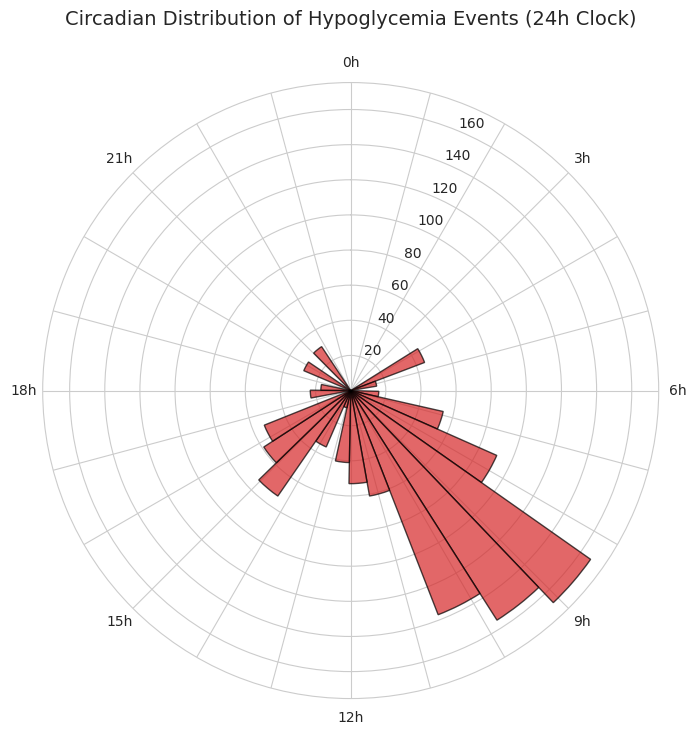

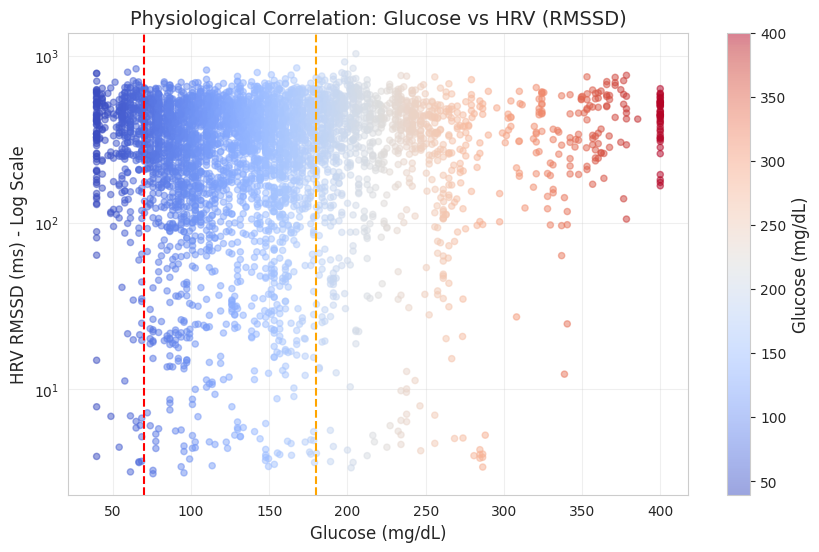

In [34]:
# ==========================================
# EXTRA VISUALIZATIONS (FOR PROFESSOR)
# ==========================================
print("\n=== EXTRA: GLUCOSE-PHYSIOLOGY CORRELATIONS ===")

def plot_extra_visuals():
    # 1. Polar Plot: Quando avvengono le ipoglicemie?
    hypo_events = df_int_clean[df_int_clean['glucose'] < HYPO_LIMIT]
    if not hypo_events.empty:
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection='polar')
        
        # Converti orario in radianti
        times = hypo_events['interval_start'].dt.hour + hypo_events['interval_start'].dt.minute/60
        theta = times * (2 * np.pi / 24)
        
        ax.hist(theta, bins=24, color='#d62728', alpha=0.7, edgecolor='black')
        ax.set_theta_direction(-1) # Senso orario
        ax.set_theta_zero_location("N") # Mezzanotte in alto
        ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
        ax.set_xticklabels([f"{h}h" if h%3==0 else "" for h in range(24)])
        plt.title("Circadian Distribution of Hypoglycemia Events (24h Clock)", y=1.08)
        plt.show()

    # 2. Correlazione Glucosio vs HRV (Scatter con densità)
    # Mostra la relazione fisiologica (RMSSD vs Glucose)
    if 'HRV_RMSSD' in df_int_clean.columns:
        plt.figure(figsize=(10, 6))
        # Campiona per evitare grafico troppo pesante
        sample = df_int_clean.sample(min(5000, len(df_int_clean)))
        
        # Scatter colorato per densità o glucosio
        sc = plt.scatter(sample['glucose'], sample['HRV_RMSSD'], 
                         c=sample['glucose'], cmap='coolwarm', alpha=0.5, s=20)
        
        plt.colorbar(sc, label='Glucose (mg/dL)')
        plt.axvline(70, color='red', linestyle='--', label='Hypo Limit')
        plt.axvline(180, color='orange', linestyle='--', label='Hyper Limit')
        
        plt.yscale('log') # RMSSD spesso logaritmico
        plt.title("Physiological Correlation: Glucose vs HRV (RMSSD)")
        plt.xlabel("Glucose (mg/dL)")
        plt.ylabel("HRV RMSSD (ms) - Log Scale")
        plt.grid(True, alpha=0.3)
        plt.show()

if 'df_int_clean' in globals() and not df_int_clean.empty:
    plot_extra_visuals()